---
# Classification of Biomedical Texts with Deep Learning: LSTM, GRU, and Self-Attention

---

In this section, we leverage PubMedBERT to generate contextualized embeddings and GloVe (300-dimensional) for static word representations. We further integrate a Bahdanau attention mechanism within a bidirectional GRU-based architecture to enhance the model’s ability to focus on relevant textual features.

In [1]:
!pip install biopython
!pip install wandb -qU

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 27.2 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import nltk
import pickle
import random
from collections import defaultdict
from collections import Counter
import os
import time
import re

from tqdm import tqdm
import numpy as np
import torch
import wandb

import matplotlib.pyplot as plt
from sklearn.metrics import precision_score
import seaborn as sns

import torch
import torch.nn as nn
from collections import Counter
import torch.optim as optim
from google.colab import files
from google.colab import drive
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data.dataset import ConcatDataset
from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import LabelEncoder
from torch.nn.utils.rnn import pad_sequence

from transformers import AutoTokenizer, AutoModel
from sklearn.metrics import accuracy_score, f1_score
from torch.optim.lr_scheduler import StepLR

from sklearn.preprocessing import label_binarize
from nltk.corpus import stopwords
from sklearn.metrics import f1_score, confusion_matrix, balanced_accuracy_score, precision_score, recall_score
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

In [ ]:
# To ensure reproducibility of the results
SEED = 200
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
data = pd.read_csv('/content/drive/MyDrive/diseases_dataset.csv')

print(data.info())
print()

data["Label"].value_counts()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38652 entries, 0 to 38651
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   PMID                38652 non-null  int64 
 1   Title               38652 non-null  object
 2   Abstract            38652 non-null  object
 3   Keywords            38652 non-null  object
 4   PublicationYear     38652 non-null  int64 
 5   MeSH_Terms          38652 non-null  object
 6   Cleaned_Abstract    38652 non-null  object
 7   Disease             38652 non-null  object
 8   Top_Relevant_Words  38652 non-null  object
 9   Label               38652 non-null  int64 
dtypes: int64(3), object(7)
memory usage: 2.9+ MB
None



,count
Label,
6,4730
7,4658
1,4639
0,4636
4,4550
8,4503
5,4452
2,3883
3,2601


In [ ]:
print(data.isna().sum())

PMID                  0
Title                 0
Abstract              0
Keywords              0
PublicationYear       0
MeSH_Terms            0
Cleaned_Abstract      0
Disease               0
Top_Relevant_Words    0
Label                 0
dtype: int64


In [ ]:
data.tail()

,PMID,Title,Abstract,Keywords,PublicationYear,MeSH_Terms,Cleaned_Abstract,Disease,Top_Relevant_Words,Label
38647,36360604,Analysis of the Number and Type of Vaccination...,"Vaccination is a very common topic, but it is ...","['infectious diseases', 'military (soldiers)',...",2022,"['Humans', '*Military Personnel', 'Poland', 'T...","vaccination common topic, rarely raised discus...",Cholera,"['vaccination', 'military', 'immunized', 'hepa...",1
38648,37547521,Clinicopathologic Spectrum of Lysozyme-Associa...,INTRODUCTION: Lysozyme-associated nephropathy ...,"['chronic myelomonocytic leukemia', 'granuloma...",2023,[],introduction lysozyme associated nephropathy l...,Leprosy,"['kidney', 'egfr', 'aki', 'min', '15', 'etiolo...",2
38649,39584999,Cystic Fibrosis Screening Efficacy and Seasona...,The California Genetic Disease Screening Progr...,"['CF', 'DNA', 'IRT', 'cystic fibrosis', 'false...",2024,[],california genetic disease screening program g...,Cystic Fibrosis,"['cutoff', 'irt', 'seasonal', 'missed', 'cf', ...",8
38650,39664903,Induction of CD4 T cell memory responses follo...,"Mycobacterium bovis, the causative agent of bo...","['BCG', 'CD4', 'T helper 1', 'cattle', 'immuno...",2024,[],"mycobacterium bovis, causative agent bovine tu...",Tuberculosis,"['btb', 'bcg', 'bovis', 'vaccine', 'cattle', '...",0
38651,32325950,Pathogenesis of Uveitis in Ebola Virus Disease...,Ebola virus disease (EVD) and emerging infecti...,"['Ebola virus disease', 'animal models', 'emer...",2020,[],ebola virus disease evd emerging infectious di...,Ebola,"['evd', 'eye', 'uveitis', 'ebola', 'vision', '...",3


In [ ]:
X = data["Cleaned_Abstract"].values
y = data["Label"].values

# Split into training (70%), validation (15%), and test (15%) sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

print(f"Training set: {len(X_train)} samples")
print(f"Validation set: {len(X_val)} samples")
print(f"Test set: {len(X_test)} samples")

NUM_CLASSES = len(set(y))
print(NUM_CLASSES)

Training set: 27056 samples
Validation set: 5798 samples
Test set: 5798 samples
9


In [ ]:
print("Training set class distribution:", Counter(y_train))
print("Validation set class distribution:", Counter(y_val))
print("Test set class distribution:", Counter(y_test))

Training set class distribution: Counter({np.int64(6): 3352, np.int64(7): 3285, np.int64(1): 3249, np.int64(0): 3215, np.int64(4): 3213, np.int64(8): 3177, np.int64(5): 3064, np.int64(2): 2705, np.int64(3): 1796})
Validation set class distribution: Counter({np.int64(7): 711, np.int64(0): 708, np.int64(1): 706, np.int64(5): 680, np.int64(6): 672, np.int64(8): 672, np.int64(4): 666, np.int64(2): 571, np.int64(3): 412})
Test set class distribution: Counter({np.int64(0): 713, np.int64(5): 708, np.int64(6): 706, np.int64(1): 684, np.int64(4): 671, np.int64(7): 662, np.int64(8): 654, np.int64(2): 607, np.int64(3): 393})


---
Bahdanau attention mechanism within a bidirectional GRU-based architecture

In [ ]:
# --- PubMedBERT Setup ---
pubmedbert_model_name = "microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract-fulltext"
tokenizer = AutoTokenizer.from_pretrained(pubmedbert_model_name)
pubmedbert = AutoModel.from_pretrained(pubmedbert_model_name).to(device)

for param in pubmedbert.parameters():
    param.requires_grad = True

BATCH_SIZE = 32

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/385 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/226k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/440M [00:00<?, ?B/s]

In [ ]:
class BahdanauAttention(nn.Module):
    """
    Bahdanau Attention Mechanism.

    This class implements the Bahdanau attention mechanism as described in the paper:
    "Neural Machine Translation by Jointly Learning to Align and Translate" by Bahdanau et al.

    Args:
        hidden_dim (int): The hidden dimension of the GRU or LSTM output.

    Attributes:
        W (nn.Linear): A linear layer for the transformation of the RNN outputs.
        v (nn.Linear): A linear layer for computing attention scores.
    """
    def __init__(self, hidden_dim):
        super(BahdanauAttention, self).__init__()
        self.W = nn.Linear(hidden_dim * 2, hidden_dim)
        self.v = nn.Linear(hidden_dim, 1, bias=False)

    def forward(self, rnn_outputs):
        """
        Apply the attention mechanism on the RNN outputs.

        Args:
            rnn_outputs (Tensor): The outputs of the RNN (GRU or LSTM).

        Returns:
            Tensor: The context vector computed by the attention mechanism.
        """
        score = torch.tanh(self.W(rnn_outputs))
        attn_weights = torch.softmax(self.v(score), dim=1)
        context = torch.sum(attn_weights * rnn_outputs, dim=1)
        return context

class PubMedBERT_GRU_Attention(nn.Module):
    """
    Model combining PubMedBERT embeddings, GRU layers, and Bahdanau Attention mechanism for multi-class classification.

    Args:
        bert_dim (int): The dimension of the PubMedBERT embeddings (usually 768).
        hidden_dim (int): The hidden dimension of the GRU layer.
        num_classes (int): The number of output classes for classification (default is 9 for multi-class classification).
        num_layers (int): The number of layers in the GRU (default is 1).
        dropout_prob (float): Dropout probability for regularization.

    Attributes:
        gru (nn.GRU): A bidirectional GRU layer.
        attention (BahdanauAttention): The Bahdanau attention mechanism.
        fc (nn.Linear): The fully connected layer to produce the output predictions.
        dropout (nn.Dropout): Dropout layer for regularization.
    """
    def __init__(self, bert_dim, hidden_dim, num_classes=9, num_layers=1, dropout_prob=0.6):
        super(PubMedBERT_GRU_Attention, self).__init__()

        self.gru = nn.GRU(
            input_size=bert_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            batch_first=True,
            bidirectional=True
        )

        self.attention = BahdanauAttention(hidden_dim)
        self.fc = nn.Linear(hidden_dim * 2, num_classes)
        self.dropout = nn.Dropout(dropout_prob)

    def forward(self, input_ids, attention_mask):
        """
        Forward pass of the model.

        Args:
            input_ids (Tensor): The tokenized input sequence IDs.
            attention_mask (Tensor): The attention mask to differentiate padding from real tokens.

        Returns:
            Tensor: The output logits for classification.
        """
        with torch.no_grad():
            bert_outputs = pubmedbert(input_ids=input_ids, attention_mask=attention_mask)
        bert_embeds = bert_outputs.last_hidden_state
        gru_out, _ = self.gru(bert_embeds)
        context = self.attention(gru_out)
        x = self.dropout(context)
        output = self.fc(x)  # Logits for multi-class classification
        return output

In [ ]:
def count_parameters(model):
    """
    Count the number of trainable parameters in the model.
    Args:
        model: The model whose parameters are to be counted.
    Returns:
        Total number of trainable parameters.
    """
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

def train_model(model, dataloader, optimizer, criterion, device):
    """
    Train the model for one epoch, calculating loss and accuracy.
    Args:
        model: The model to train.
        dataloader: DataLoader for the training dataset.
        optimizer: Optimizer for model parameters.
        criterion: Loss function.
        device: CPU/GPU device.
    Returns:
        Average loss and accuracy for the epoch.
    """
    model.train()
    total_loss = 0
    total_correct = 0
    total_samples = 0

    for batch in dataloader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        optimizer.zero_grad()
        logits = model(input_ids, attention_mask)

        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        preds = torch.argmax(logits, dim=1).cpu().detach().numpy()
        total_correct += np.sum(preds == labels.cpu().numpy())
        total_samples += labels.size(0)

    avg_loss = total_loss / len(dataloader)
    avg_accuracy = total_correct / total_samples
    return avg_loss, avg_accuracy

def evaluate_model(model, dataloader, criterion, device):
    """
    Validate the model for one epoch, including precision, F1, balanced accuracy, and recall.
    Args:
        model: Model instance.
        dataloader: DataLoader for validation data.
        criterion: Loss function (CrossEntropyLoss).
        device: CPU/GPU.
    Returns:
        Average validation loss, accuracy, F1-score.
    """
    model.eval()
    all_preds = []
    all_labels = []
    val_loss = 0.0

    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Evaluating"):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            logits = model(input_ids, attention_mask)
            loss = criterion(logits, labels)
            val_loss += loss.item()

            preds = torch.argmax(logits, dim=1).cpu().numpy()
            labels_cpu = labels.cpu().numpy()

            all_preds.extend(preds)
            all_labels.extend(labels_cpu)

    val_loss /= len(dataloader)
    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)

    acc = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds, average="weighted")

    return acc, f1, val_loss

def test_model(model, test_loader, criterion, device):
    """
    Evaluate the model on the test dataset, calculating loss, accuracy, F1-score, precision, recall, and balanced accuracy.
    Args:
        model: The model to evaluate.
        test_loader: DataLoader for the test dataset.
        criterion: Loss function (CrossEntropyLoss).
        device: CPU/GPU device.
    Returns:
        Average test loss, accuracy, F1-score, balanced accuracy, recall, and precision.
    """
    model.eval()
    total_loss = 0
    total_accuracy = 0
    all_labels = []
    all_preds = []

    with torch.no_grad():
        for batch in test_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            target_tensor = batch['labels'].to(device)

            output = model(input_ids, attention_mask)
            loss = criterion(output, target_tensor)
            total_loss += loss.item()

            batch_accuracy = accuracy_score(target_tensor.cpu(), torch.argmax(output, dim=1).cpu())
            total_accuracy += batch_accuracy * len(target_tensor)

            preds = torch.argmax(output, dim=1).cpu().numpy()
            labels = target_tensor.cpu().numpy()

            all_preds.extend(preds)
            all_labels.extend(labels)

    avg_loss = total_loss / len(test_loader)
    avg_accuracy = total_accuracy / len(test_loader.dataset)
    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)

    f1 = f1_score(all_labels, all_preds, average="weighted", zero_division=0)
    balanced_acc = balanced_accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds, average="weighted", zero_division=0)
    recall = recall_score(all_labels, all_preds, average="weighted", zero_division=0)

    return avg_loss, avg_accuracy, f1, balanced_acc, recall, precision

In [ ]:
BERT_DIM = 768
HIDDEN_DIM = 256
DROPOUT = 0.6

model = PubMedBERT_GRU_Attention(BERT_DIM, HIDDEN_DIM, dropout_prob=DROPOUT).to(device)
print()
print(f"{count_parameters(model)} model parameters")
print()
print(model)


1712137 model parameters

PubMedBERT_GRU_Attention(
  (gru): GRU(768, 256, batch_first=True, bidirectional=True)
  (attention): BahdanauAttention(
    (W): Linear(in_features=512, out_features=256, bias=True)
    (v): Linear(in_features=256, out_features=1, bias=False)
  )
  (fc): Linear(in_features=512, out_features=9, bias=True)
  (dropout): Dropout(p=0.6, inplace=False)
)


---

#1. Use of PubMedBERT as contextual embeddings

---

PubMedBERT is a model pre-trained on a corpus of biomedical texts, and generates contextual embeddings.

In [ ]:
class PubMedBERTBinaryDataset(Dataset):
    """
    Dataset class for multi-class classification using PubMedBERT embeddings.

    Args:
        texts (list of str): A list of raw text sequences.
        labels (list of int): A list of integer labels (0-8) corresponding to each text.
        tokenizer (transformers tokenizer): A tokenizer to preprocess the text data.
        max_length (int): Maximum length for padding/truncation. Default is 400.

    Attributes:
        texts (list of str): The raw text data.
        encodings (dict): Tokenized text data with input IDs and attention masks.
        labels (Tensor): Tensor of integer labels for the classification task.
    """

    def __init__(self, texts, labels, tokenizer, max_length=400):
        self.texts = texts
        self.encodings = tokenizer(texts, padding='max_length', truncation=True, max_length=max_length, return_tensors='pt')
        self.labels = torch.tensor(labels, dtype=torch.long)

    def __getitem__(self, idx):
        """
        Retrieve a single sample from the dataset.

        Args:
            idx (int): Index of the sample to retrieve.

        Returns:
            dict: Contains input IDs, attention masks, and the corresponding label and raw text.
        """
        item = {key: val[idx] for key, val in self.encodings.items()}
        item['labels'] = self.labels[idx]
        item['text'] = self.texts[idx]
        return item

    def __len__(self):
        """
        Returns the total number of samples in the dataset.

        Returns:
            int: Number of samples in the dataset.
        """
        return len(self.labels)

In [ ]:
# --- Load Data ---
train_dataset = PubMedBERTBinaryDataset(X_train.tolist(), y_train, tokenizer)
val_dataset = PubMedBERTBinaryDataset(X_val.tolist(), y_val, tokenizer)
test_dataset = PubMedBERTBinaryDataset(X_test.tolist(), y_test, tokenizer)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

# Combine the training and validation datasets (for test)
combined_dataset = ConcatDataset([train_dataset, val_dataset])
combined_loader = DataLoader(combined_dataset, batch_size=BATCH_SIZE, shuffle=True)

---
## 1.1 Optimisation phase

1.1.1 Optimizer selection

In [ ]:
num_epochs = 5
learning_rate = 1e-4
weight_decay = 1e-3
criterion = torch.nn.CrossEntropyLoss()

optimizers = {
    'Adam': optim.Adam,
    'AdamW': optim.AdamW,
    'RMSprop': optim.RMSprop,
}

all_train_losses = {}
all_val_losses = {}
all_train_accs = {}
all_val_accs = {}

for optimizer_name, optimizer_class in optimizers.items():
    print(f"\n🔹 Training with optimizer: {optimizer_name}")

    model = PubMedBERT_GRU_Attention(BERT_DIM, HIDDEN_DIM, dropout_prob=DROPOUT).to(device)
    print(model)

    optimizer = optimizer_class(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2, verbose=True)

    wandb.init(project='Multi_Class_Pubmedbert_Attention_OptimizerSearch', name=f"{optimizer_name}_run", config={
        'learning_rate': learning_rate,
        'num_epochs': num_epochs,
        'optimizer': optimizer_name,
        'model': 'PubMedBERT_Bi_GRU_Bahdanau_Attention',
        'hidden_dim': HIDDEN_DIM,
        'dropout_prob': DROPOUT
    })

    num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"Total trainable parameters: {num_params}")

    train_losses, val_losses = [], []
    train_accs, val_accs = [], []
    best_val_loss = float('inf')

    for epoch in range(num_epochs):
        start_time = time.time()

        train_loss, train_acc = train_model(model, train_loader, optimizer, criterion, device)
        train_losses.append(train_loss)
        train_accs.append(train_acc)

        val_acc, f1, val_loss = evaluate_model(model, val_loader, criterion, device)
        val_accs.append(val_acc)
        val_losses.append(val_loss)

        end_time = time.time()
        duration = end_time - start_time

        print(
            f"Opt: {optimizer_name} | Epoch {epoch+1}/{num_epochs} - "
            f"TL: {train_loss:.4f}, VL: {val_loss:.4f}, "
            f"TA: {train_acc:.2%}, VA: {val_acc:.2%}, F1: {f1:.2%}, "
            f"Time: {duration/60:.2f} min"
        )

        wandb.log({
            'train_loss': train_loss,
            'val_loss': val_loss,
            'train_acc': train_acc,
            'val_acc': val_acc,
            'val_f1': f1,
        })

        scheduler.step(val_loss)

    all_train_losses[optimizer_name] = train_losses
    all_val_losses[optimizer_name] = val_losses
    all_train_accs[optimizer_name] = train_accs
    all_val_accs[optimizer_name] = val_accs

    wandb.finish()

---
Adam optimizer is selected.

1.1.2 Depth value selection

In [ ]:
depth_values = [1, 2, 3]
num_epochs = 5
learning_rate = 1e-4
weight_decay = 1e-3
criterion = torch.nn.CrossEntropyLoss()

all_train_losses = {}
all_val_losses = {}
all_train_accs = {}
all_val_accs = {}

for depth in depth_values:
    print(f"\n🔹 Training with GRU depth: {depth}")

    model = PubMedBERT_GRU_Attention(
        bert_dim=BERT_DIM,
        hidden_dim=HIDDEN_DIM,
        num_classes=9,
        num_layers=depth,
        dropout_prob=DROPOUT
    ).to(device)

    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2, verbose=True)

    wandb.init(
        project='Multi_Class_Pubmedbert_Attention_DepthSearch',
        name=f"Depth_{depth}_run",
        config={
            'learning_rate': learning_rate,
            'num_epochs': num_epochs,
            'optimizer': 'Adam',
            'gru_depth': depth,
            'model': 'PubMedBERT_Bi_GRU_Bahdanau_Attention',
            'hidden_dim': HIDDEN_DIM,
            'dropout_prob': DROPOUT
        }
    )

    num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"Total trainable parameters (depth={depth}): {num_params}")

    train_losses, val_losses = [], []
    train_accs, val_accs = [], []
    best_val_loss = float('inf')

    for epoch in range(num_epochs):
        start_time = time.time()

        train_loss, train_acc = train_model(model, train_loader, optimizer, criterion, device)
        val_acc, f1, val_loss = evaluate_model(model, val_loader, criterion, device)

        train_losses.append(train_loss)
        train_accs.append(train_acc)
        val_losses.append(val_loss)
        val_accs.append(val_acc)

        end_time = time.time()
        duration = end_time - start_time

        print(
            f"Depth: {depth} | Epoch {epoch+1}/{num_epochs} - "
            f"TL: {train_loss:.4f}, VL: {val_loss:.4f}, "
            f"TA: {train_acc:.2%}, VA: {val_acc:.2%}, F1: {f1:.2%}, "
            f"Time: {duration/60:.2f} min"
        )

        wandb.log({
            'train_loss': train_loss,
            'val_loss': val_loss,
            'train_acc': train_acc,
            'val_acc': val_acc,
            'val_f1': f1,
        })

        scheduler.step(val_loss)

    all_train_losses[f'depth_{depth}'] = train_losses
    all_val_losses[f'depth_{depth}'] = val_losses
    all_train_accs[f'depth_{depth}'] = train_accs
    all_val_accs[f'depth_{depth}'] = val_accs

    wandb.finish()


🔹 Training with GRU depth: 1


wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: wilfried-mvomoeto (wilfried-mvomoeto-university-of-li-ge) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Total trainable parameters (depth=1): 1712137


Evaluating: 100%|██████████| 182/182 [02:09<00:00,  1.41it/s]


Depth: 1 | Epoch 1/5 - TL: 0.7334, VL: 0.2954, TA: 77.97%, VA: 91.26%, F1: 91.14%, Time: 12.69 min


Evaluating: 100%|██████████| 182/182 [02:09<00:00,  1.41it/s]


Depth: 1 | Epoch 2/5 - TL: 0.2679, VL: 0.2730, TA: 91.96%, VA: 91.31%, F1: 91.30%, Time: 12.70 min


Evaluating: 100%|██████████| 182/182 [02:09<00:00,  1.41it/s]


Depth: 1 | Epoch 3/5 - TL: 0.2448, VL: 0.2652, TA: 92.36%, VA: 91.43%, F1: 91.37%, Time: 12.69 min


Evaluating: 100%|██████████| 182/182 [02:09<00:00,  1.41it/s]


Depth: 1 | Epoch 4/5 - TL: 0.2336, VL: 0.2640, TA: 92.73%, VA: 91.79%, F1: 91.75%, Time: 12.69 min


Evaluating: 100%|██████████| 182/182 [02:08<00:00,  1.41it/s]

Depth: 1 | Epoch 5/5 - TL: 0.2249, VL: 0.2615, TA: 93.00%, VA: 91.86%, F1: 91.81%, Time: 12.68 min


train_acc,▁████
train_loss,█▂▁▁▁
val_acc,▁▂▃▇█
val_f1,▁▃▃▇█
val_loss,█▃▂▂▁
train_acc,0.93
train_loss,0.22491
val_acc,0.91859
val_f1,0.91815
val_loss,0.26149



🔹 Training with GRU depth: 2


Total trainable parameters (depth=2): 2894857


Evaluating: 100%|██████████| 182/182 [02:12<00:00,  1.38it/s]


Depth: 2 | Epoch 1/5 - TL: 0.6391, VL: 0.3060, TA: 80.28%, VA: 90.50%, F1: 90.47%, Time: 13.33 min


Evaluating: 100%|██████████| 182/182 [02:11<00:00,  1.38it/s]


Depth: 2 | Epoch 2/5 - TL: 0.2703, VL: 0.2834, TA: 91.84%, VA: 90.81%, F1: 90.87%, Time: 13.32 min


Evaluating: 100%|██████████| 182/182 [02:11<00:00,  1.38it/s]


Depth: 2 | Epoch 3/5 - TL: 0.2452, VL: 0.2563, TA: 92.37%, VA: 91.76%, F1: 91.74%, Time: 13.32 min


Evaluating: 100%|██████████| 182/182 [02:11<00:00,  1.39it/s]


Depth: 2 | Epoch 4/5 - TL: 0.2342, VL: 0.2704, TA: 92.65%, VA: 91.51%, F1: 91.43%, Time: 13.31 min


Evaluating: 100%|██████████| 182/182 [02:12<00:00,  1.38it/s]

Depth: 2 | Epoch 5/5 - TL: 0.2249, VL: 0.2533, TA: 92.95%, VA: 92.03%, F1: 92.02%, Time: 13.32 min


train_acc,▁▇███
train_loss,█▂▁▁▁
val_acc,▁▂▇▆█
val_f1,▁▃▇▅█
val_loss,█▅▁▃▁
train_acc,0.92948
train_loss,0.22493
val_acc,0.92032
val_f1,0.92015
val_loss,0.25327



🔹 Training with GRU depth: 3


Total trainable parameters (depth=3): 4077577


Evaluating: 100%|██████████| 182/182 [02:14<00:00,  1.35it/s]


Depth: 3 | Epoch 1/5 - TL: 0.6080, VL: 0.3145, TA: 81.07%, VA: 90.62%, F1: 90.58%, Time: 13.92 min


Evaluating: 100%|██████████| 182/182 [02:14<00:00,  1.35it/s]


Depth: 3 | Epoch 2/5 - TL: 0.2809, VL: 0.3050, TA: 91.36%, VA: 90.89%, F1: 90.79%, Time: 13.91 min


Evaluating: 100%|██████████| 182/182 [02:14<00:00,  1.36it/s]


Depth: 3 | Epoch 3/5 - TL: 0.2576, VL: 0.2698, TA: 92.01%, VA: 91.20%, F1: 91.22%, Time: 13.90 min


Evaluating: 100%|██████████| 182/182 [02:14<00:00,  1.35it/s]


Depth: 3 | Epoch 4/5 - TL: 0.2467, VL: 0.2730, TA: 92.29%, VA: 91.39%, F1: 91.36%, Time: 13.91 min


Evaluating: 100%|██████████| 182/182 [02:13<00:00,  1.36it/s]

Depth: 3 | Epoch 5/5 - TL: 0.2355, VL: 0.2644, TA: 92.50%, VA: 91.70%, F1: 91.62%, Time: 13.90 min


train_acc,▁▇███
train_loss,█▂▁▁▁
val_acc,▁▃▅▆█
val_f1,▁▂▅▆█
val_loss,█▇▂▂▁
train_acc,0.92504
train_loss,0.23551
val_acc,0.91704
val_f1,0.91616
val_loss,0.26439


---
Depth value is set to 2.

1.3 Leanring rate value selection

In [ ]:
learning_rates = [9e-5, 7e-5, 5e-5]
num_epochs = 5
criterion = torch.nn.CrossEntropyLoss()

all_train_losses = {}
all_val_losses = {}
all_train_accs = {}
all_val_accs = {}

for lr in learning_rates:
    print(f"\n🔹 Training with learning rate: {lr}")

    model = PubMedBERT_GRU_Attention(
        bert_dim=BERT_DIM,
        hidden_dim=HIDDEN_DIM,
        num_classes=9,
        num_layers=2,
        dropout_prob=DROPOUT
    ).to(device)

    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-3)
    scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2, verbose=True)

    wandb.init(
        project='Multi_Class_Pubmedbert_Attention_LRTuning',
        name=f"LR_{lr}_run",
        config={
            'learning_rate': lr,
            'num_epochs': num_epochs,
            'optimizer': 'Adam',
            'gru_depth': depth,
            'model': 'PubMedBERT_Bi_GRU_Bahdanau_Attention',
            'hidden_dim': HIDDEN_DIM,
            'dropout_prob': DROPOUT
        }
    )

    num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"Total trainable parameters (lr={lr}): {num_params}")

    train_losses, val_losses = [], []
    train_accs, val_accs = [], []
    best_val_loss = float('inf')

    for epoch in range(num_epochs):
        start_time = time.time()

        train_loss, train_acc = train_model(model, train_loader, optimizer, criterion, device)
        val_acc, f1, val_loss = evaluate_model(model, val_loader, criterion, device)

        train_losses.append(train_loss)
        train_accs.append(train_acc)
        val_losses.append(val_loss)
        val_accs.append(val_acc)

        end_time = time.time()
        duration = end_time - start_time

        print(
            f"LR: {lr} | Epoch {epoch+1}/{num_epochs} - "
            f"TL: {train_loss:.4f}, VL: {val_loss:.4f}, "
            f"TA: {train_acc:.2%}, VA: {val_acc:.2%}, F1: {f1:.2%}, "
            f"Time: {duration/60:.2f} min"
        )

        wandb.log({
            'train_loss': train_loss,
            'val_loss': val_loss,
            'train_acc': train_acc,
            'val_acc': val_acc,
            'val_f1': f1,
        })

        scheduler.step(val_loss)

    all_train_losses[f'lr_{lr}'] = train_losses
    all_val_losses[f'lr_{lr}'] = val_losses
    all_train_accs[f'lr_{lr}'] = train_accs
    all_val_accs[f'lr_{lr}'] = val_accs

    wandb.finish()


🔹 Training with learning rate: 9e-05


Total trainable parameters (lr=9e-05): 2894857


Evaluating: 100%|██████████| 182/182 [02:05<00:00,  1.44it/s]


LR: 9e-05 | Epoch 1/5 - TL: 0.6746, VL: 0.2990, TA: 79.27%, VA: 90.74%, F1: 90.72%, Time: 12.76 min


Evaluating: 100%|██████████| 182/182 [02:05<00:00,  1.45it/s]


LR: 9e-05 | Epoch 2/5 - TL: 0.2705, VL: 0.2730, TA: 91.64%, VA: 91.24%, F1: 91.19%, Time: 12.75 min


Evaluating: 100%|██████████| 182/182 [02:05<00:00,  1.45it/s]


LR: 9e-05 | Epoch 3/5 - TL: 0.2500, VL: 0.2676, TA: 92.31%, VA: 91.70%, F1: 91.70%, Time: 12.74 min


Evaluating: 100%|██████████| 182/182 [02:05<00:00,  1.45it/s]


LR: 9e-05 | Epoch 4/5 - TL: 0.2352, VL: 0.2651, TA: 92.78%, VA: 91.86%, F1: 91.88%, Time: 12.74 min


Evaluating: 100%|██████████| 182/182 [02:05<00:00,  1.44it/s]

LR: 9e-05 | Epoch 5/5 - TL: 0.2273, VL: 0.2564, TA: 92.93%, VA: 92.14%, F1: 92.09%, Time: 12.75 min


learning_rate,▁▁▁▁▁
train_acc,▁▇███
train_loss,█▂▁▁▁
val_acc,▁▄▆▇█
val_f1,▁▃▆▇█
val_loss,█▄▃▂▁
learning_rate,9e-05
train_acc,0.92926
train_loss,0.22727
val_acc,0.92135
val_f1,0.92093



🔹 Training with learning rate: 7e-05


Total trainable parameters (lr=7e-05): 2894857


Evaluating: 100%|██████████| 182/182 [02:06<00:00,  1.44it/s]


LR: 7e-05 | Epoch 1/5 - TL: 0.7341, VL: 0.3170, TA: 77.93%, VA: 90.12%, F1: 90.15%, Time: 12.76 min


Evaluating: 100%|██████████| 182/182 [02:05<00:00,  1.44it/s]


LR: 7e-05 | Epoch 2/5 - TL: 0.2799, VL: 0.2788, TA: 91.41%, VA: 91.36%, F1: 91.33%, Time: 12.74 min


Evaluating: 100%|██████████| 182/182 [02:05<00:00,  1.44it/s]


LR: 7e-05 | Epoch 3/5 - TL: 0.2532, VL: 0.2708, TA: 92.19%, VA: 91.84%, F1: 91.77%, Time: 12.75 min


Evaluating: 100%|██████████| 182/182 [02:05<00:00,  1.45it/s]


LR: 7e-05 | Epoch 4/5 - TL: 0.2407, VL: 0.2615, TA: 92.51%, VA: 91.86%, F1: 91.79%, Time: 12.75 min


Evaluating: 100%|██████████| 182/182 [02:05<00:00,  1.45it/s]

LR: 7e-05 | Epoch 5/5 - TL: 0.2293, VL: 0.2712, TA: 92.86%, VA: 91.12%, F1: 91.14%, Time: 12.75 min


learning_rate,▁▁▁▁▁
train_acc,▁▇███
train_loss,█▂▁▁▁
val_acc,▁▆██▅
val_f1,▁▆██▅
val_loss,█▃▂▁▂
learning_rate,7e-05
train_acc,0.92859
train_loss,0.2293
val_acc,0.91118
val_f1,0.91135



🔹 Training with learning rate: 5e-05


Total trainable parameters (lr=5e-05): 2894857


Evaluating: 100%|██████████| 182/182 [02:05<00:00,  1.45it/s]


LR: 5e-05 | Epoch 1/5 - TL: 0.9081, VL: 0.3390, TA: 72.69%, VA: 89.57%, F1: 89.51%, Time: 12.74 min


Evaluating: 100%|██████████| 182/182 [02:05<00:00,  1.45it/s]


LR: 5e-05 | Epoch 2/5 - TL: 0.2931, VL: 0.2884, TA: 91.33%, VA: 91.12%, F1: 91.05%, Time: 12.74 min


Evaluating: 100%|██████████| 182/182 [02:05<00:00,  1.45it/s]


LR: 5e-05 | Epoch 3/5 - TL: 0.2598, VL: 0.2758, TA: 91.98%, VA: 91.45%, F1: 91.41%, Time: 12.74 min


Evaluating: 100%|██████████| 182/182 [02:05<00:00,  1.45it/s]


LR: 5e-05 | Epoch 4/5 - TL: 0.2445, VL: 0.2718, TA: 92.30%, VA: 91.43%, F1: 91.43%, Time: 12.74 min


Evaluating: 100%|██████████| 182/182 [02:05<00:00,  1.45it/s]

LR: 5e-05 | Epoch 5/5 - TL: 0.2317, VL: 0.2643, TA: 92.74%, VA: 91.57%, F1: 91.53%, Time: 12.74 min


learning_rate,▁▁▁▁▁
train_acc,▁████
train_loss,█▂▁▁▁
val_acc,▁▆███
val_f1,▁▆███
val_loss,█▃▂▂▁
learning_rate,5e-05
train_acc,0.92741
train_loss,0.23167
val_acc,0.91566
val_f1,0.91535


---
Learning rate value is set to $ 9 \cdot 10^{-5}$.

---

#2. Use of Glove (300d) as word embeddings

---

GloVe (Global Vectors for Word Representation) is a type of word embedding developed by the Stanford NLP Group.

In [ ]:
def tokenize(text):
    """
    Tokenizes the input text by converting it to lowercase and splitting it into words.

    Args:
        text: A string containing the text to be tokenized.

    Returns:
        A list of tokens (words) from the text.
    """
    return re.findall(r'\b\w+\b', text.lower())

In [ ]:
all_tokens = [token for text in X_train for token in tokenize(text)]
vocab = Counter(all_tokens)
filtered_vocab = {word: freq for word, freq in vocab.items() if freq >= 2}
VOCAB_SIZE =  40000

sorted_filtered_vocab = dict(sorted(filtered_vocab.items(), key=lambda item: item[1], reverse=True)[:VOCAB_SIZE])

word_to_index = {word: idx for idx, (word, _) in enumerate(sorted_filtered_vocab.items(), 1)}
word_to_index["<PAD>"] = 0
word_to_index["<UNK>"] = len(word_to_index)

index_to_word = {idx: word for word, idx in word_to_index.items()}

In [ ]:
def text_to_sequence(text):
    """
    Converts the tokenized text into a sequence of indices based on a word-to-index mapping.

    Args:
        text: A string containing the text to be converted.

    Returns:
        A list of integers representing the sequence of token indices.
    """
    return [word_to_index.get(token, word_to_index["<UNK>"]) for token in tokenize(text)]

def pad_to_tensor(sequences, max_len=None):
    """
    Pads sequences to the specified maximum length, or truncates them if they exceed it.

    Args:
        sequences: A list of sequences (each sequence is a list of integers).
        max_len: The maximum length to which sequences should be padded. If None, no padding is applied.

    Returns:
        A tensor containing the padded (or truncated) sequences.
    """
    padded_sequences = [torch.tensor(seq, dtype=torch.long) for seq in sequences]
    if max_len:
        padded_sequences = [seq[:max_len] for seq in padded_sequences]
        padded_sequences = [
            torch.cat([seq, torch.zeros(max_len - len(seq), dtype=torch.long)], 0) if len(seq) < max_len else seq
            for seq in padded_sequences
        ]

    return torch.stack(padded_sequences)

class TextDataset(Dataset):
    """
    Custom Dataset for handling text data and labels.

    Args:
        X_data: Input features (e.g., tokenized text).
        y_data: Labels corresponding to the text data.
        raw_text_data: (Optional) The raw text data for reference (default is None).
    """
    def __init__(self, X_data, y_data, raw_text_data=None):
        self.X = torch.tensor(X_data, dtype=torch.long)
        self.y = torch.tensor(y_data, dtype=torch.long)
        self.raw_text_data = raw_text_data

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        input_tensor = self.X[idx]
        target_tensor = self.y[idx]
        raw_text = self.raw_text_data[idx] if self.raw_text_data is not None else None
        return input_tensor, target_tensor, raw_text

def load_glove_embeddings(glove_path, word_to_index, embedding_dim):
    """Loads GloVe embeddings and returns an embedding matrix."""
    embedding_matrix = np.zeros((len(word_to_index), embedding_dim), dtype='float32')
    with open(glove_path, 'r', encoding="utf-8") as f:
        for line in f:
            values = line.strip().split()
            word = values[0]
            if word in word_to_index:
                vector = np.asarray(values[1:], dtype='float32')
                embedding_matrix[word_to_index[word]] = vector

    return torch.tensor(embedding_matrix, dtype=torch.float)

In [ ]:
X_train_seq = [text_to_sequence(text) for text in X_train]
X_val_seq = [text_to_sequence(text) for text in X_val]
X_test_seq = [text_to_sequence(text) for text in X_test]

print(X_train_seq[0])
max_length = 400

X_train_tensor = pad_to_tensor(X_train_seq, max_len=max_length)
X_val_tensor = pad_to_tensor(X_val_seq, max_len=max_length)
X_test_tensor = pad_to_tensor(X_test_seq, max_len=max_length)

print(f"Train Tensor Shape: {X_train_tensor.shape}, Type: {X_train_tensor.dtype}")
print(f"Validation Tensor Shape: {X_val_tensor.shape}, Type: {X_val_tensor.dtype}")
print(f"Test Tensor Shape: {X_test_tensor.shape}, Type: {X_test_tensor.dtype}")

y_train_tensor = torch.tensor(y_train)
y_val_tensor = torch.tensor(y_val)
y_test_tensor = torch.tensor(y_test)

[79, 347, 3, 40, 127, 119, 11, 445, 2521, 351, 89, 42, 342, 763, 7415, 333, 5299, 6666, 133, 448, 52, 18, 1464, 79, 4, 499, 295, 233, 31, 6666, 1243, 38, 18, 699, 389, 2717, 119, 11, 445, 161, 4, 2639, 611, 83, 1490, 387, 694, 112, 6666, 79, 412, 1440, 913, 557, 3331, 40001, 622, 728, 128, 4687, 909, 2871, 458, 64, 607, 4412, 219, 4, 190, 19, 7153, 8005, 190, 287, 375, 876, 74, 1354, 458, 93, 4, 229, 9, 654, 132, 6666, 233, 31, 1243, 917, 2298, 213, 38, 4283, 18, 775, 43, 114, 136, 445, 9, 337, 6666, 40, 429, 80, 11, 301, 79]
Train Tensor Shape: torch.Size([27056, 400]), Type: torch.int64
Validation Tensor Shape: torch.Size([5798, 400]), Type: torch.int64
Test Tensor Shape: torch.Size([5798, 400]), Type: torch.int64


In [ ]:
class GloVe_GRU_BahdanauAttention(nn.Module):
    """
    Model using GloVe embeddings, GRU layers, and Bahdanau Attention for classification.

    Args:
        embedding_matrix (Tensor): Pretrained GloVe embedding matrix.
        hidden_dim (int): Hidden size for the GRU.
        num_classes (int): Output classes.
        num_layers (int): GRU depth.
        dropout_prob (float): Dropout rate.
    """
    def __init__(self, embedding_matrix, hidden_dim, num_classes=NUM_CLASSES, num_layers=1, dropout_prob=0.6):
        super(GloVe_GRU_BahdanauAttention, self).__init__()

        vocab_size, embedding_dim = embedding_matrix.shape
        self.embedding = nn.Embedding.from_pretrained(embedding_matrix, freeze=False)

        self.gru = nn.GRU(
            input_size=embedding_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            batch_first=True,
            bidirectional=True
        )

        self.attention = BahdanauAttention(hidden_dim)
        self.fc = nn.Linear(hidden_dim * 2, num_classes)
        self.dropout = nn.Dropout(dropout_prob)

    def forward(self, x):
        """
        Args:
            x (Tensor): Tensor of token indices (batch_size, seq_len)

        Returns:
            Tensor: Output logits for classification.
        """
        embedded = self.embedding(x)
        gru_out, _ = self.gru(embedded)
        context = self.attention(gru_out)
        x = self.dropout(context)
        output = self.fc(x)
        return output

In [ ]:
def calculate_accuracy(y_pred, y_true):
    """
    Compute classification accuracy for multi-class predictions.

    Args:
        y_pred (Tensor): Raw output logits from the model of shape (batch_size, num_classes).
        y_true (Tensor): Ground truth labels of shape (batch_size,).

    Returns:
        float: Accuracy score over the batch.
    """
    preds = torch.argmax(y_pred, dim=1)
    correct = (preds == y_true).sum().item()
    total = y_true.size(0)
    return correct / total

def train_epoch_glove(model, train_loader, optimizer, criterion, device):
    """
    Train the model for one epoch on the training data using GloVe embeddings.

    Args:
        model (nn.Module): The model to be trained.
        train_loader (DataLoader): DataLoader for the training data.
        optimizer (torch.optim.Optimizer): Optimizer for training.
        criterion (nn.Module): Loss function.
        device (torch.device): Device to run the training on (CPU or CUDA).

    Returns:
        Tuple[float, float]: Average loss and accuracy over the epoch.
    """
    model.train()
    total_loss, total_accuracy = 0, 0

    for batch in train_loader:
        if len(batch) == 3:
            input_tensor, target_tensor, _ = batch  # Ignore raw_text
        input_tensor, target_tensor = input_tensor.to(device), target_tensor.to(device)

        optimizer.zero_grad()
        output = model(input_tensor)

        loss = criterion(output, target_tensor)
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()

        acc = calculate_accuracy(output, target_tensor)
        total_loss += loss.item()
        total_accuracy += acc * input_tensor.size(0)

    avg_loss = total_loss / len(train_loader)
    avg_accuracy = total_accuracy / len(train_loader.dataset)

    return avg_loss, avg_accuracy


def validate_epoch_glove(model, val_loader, criterion, device):
    """
    Validate the model on the validation set and compute weighted F1 and accuracy.

    Args:
        model (nn.Module): The trained model.
        val_loader (DataLoader): DataLoader for the validation data.
        criterion (nn.Module): Loss function.
        device (torch.device): Device to run validation on.

    Returns:
        Tuple[float, float, float]: Average loss, F1 score, and accuracy.
    """
    model.eval()
    total_loss, total_accuracy = 0, 0

    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch in val_loader:
            if len(batch) == 3:
                input_tensor, target_tensor, _ = batch  # Ignore raw_text
            input_tensor, target_tensor = input_tensor.to(device), target_tensor.to(device)

            output = model(input_tensor)  # logits

            loss = criterion(output, target_tensor)
            acc = calculate_accuracy(output, target_tensor)

            total_loss += loss.item()
            total_accuracy += acc * input_tensor.size(0)

            preds = torch.argmax(output, dim=1).cpu().numpy()
            labels = target_tensor.cpu().numpy()

            all_preds.extend(preds)
            all_labels.extend(labels)

    avg_loss = total_loss / len(val_loader)
    avg_accuracy = total_accuracy / len(val_loader.dataset)
    f1 = f1_score(all_labels, all_preds, average='weighted', zero_division=0)

    return  avg_accuracy, f1, avg_loss

def test_epoch_glove(model, val_loader, criterion, device):
    """
    Validate the model and compute a complete set of metrics for multi-class classification.

    Args:
        model (nn.Module): The trained model.
        val_loader (DataLoader): DataLoader for the validation data.
        criterion (nn.Module): Loss function.
        device (torch.device): Device to run validation on.

    Returns:
        Tuple[float, float, float, float, float, float]:
            Average loss, accuracy, F1 score (weighted),
            balanced accuracy, recall (weighted), precision (weighted).
    """
    model.eval()
    total_loss, total_accuracy = 0, 0

    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch in val_loader:
            if len(batch) == 3:
                input_tensor, target_tensor, _ = batch  # Ignore raw_text
            else:
                input_tensor, target_tensor = batch

            input_tensor = input_tensor.to(device)
            target_tensor = target_tensor.to(device).long()

            output = model(input_tensor)  # logits

            loss = criterion(output, target_tensor)
            acc = calculate_accuracy(output, target_tensor)

            total_loss += loss.item()
            total_accuracy += acc * input_tensor.size(0)

            preds = torch.argmax(output, dim=1).cpu().numpy()
            labels = target_tensor.cpu().numpy()

            all_preds.extend(preds)
            all_labels.extend(labels)

    avg_loss = total_loss / len(val_loader)
    avg_accuracy = total_accuracy / len(val_loader.dataset)
    f1 = f1_score(all_labels, all_preds, average='weighted', zero_division=0)
    balanced_acc = balanced_accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds, average='weighted', zero_division=0)
    recall = recall_score(all_labels, all_preds, average='weighted', zero_division=0)

    return avg_loss, avg_accuracy, f1, balanced_acc, recall, precision

In [ ]:
EMBEDDING_DIM = 300
embedding_matrix = load_glove_embeddings('/content/drive/MyDrive/glove/glove.6B.300d.txt', word_to_index, EMBEDDING_DIM)

train_dataset = TextDataset(X_train_tensor, y_train, raw_text_data=X_train)
val_dataset = TextDataset(X_val_tensor, y_val, raw_text_data=X_val)
test_dataset = TextDataset(X_test_tensor, y_test, raw_text_data=X_test)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

<ipython-input-16-811d6649565c>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X = torch.tensor(X_data, dtype=torch.long)


---
## 2.1 Optimisation phase

2.1.1 Optimizer selection

In [ ]:
num_epochs = 7
learning_rate = 7e-4
loss_function = torch.nn.CrossEntropyLoss()

optimizers = {
    'RMSprop': optim.RMSprop,
    'Adam': optim.Adam,
    'AdamW': optim.AdamW,
}

for optimizer_name, optimizer_class in optimizers.items():
    print(f"\n🔹 Training with optimizer: {optimizer_name}")

    model = GloVe_GRU_BahdanauAttention(embedding_matrix=embedding_matrix, hidden_dim=350, num_layers=1, dropout_prob=0.8).to(device)
    optimizer = optimizer_class(model.parameters(), lr=learning_rate)
    wandb.init(project='Multi_Class_Optimizer_Comparison_gru_attention_glove300d', name=f"{optimizer_name}_run", config={
        'learning_rate': learning_rate,
        'num_epochs': num_epochs,
        'optimizer': optimizer_name,
        'model': 'GRU_Model',
        'embedding_dim': 300,
        'hidden_dim': 350,
        'dropout_prob': 0.5
    })

    print(model)
    num_params = count_parameters(model)
    print(f"Total trainable parameters: {num_params}")

    train_losses, val_losses = [], []
    train_accs, val_accs = [], []
    val_f1s = []

    with tqdm(total=num_epochs, desc=f"Optimizer: {optimizer_name}", unit="epoch") as pbar:
        for epoch in range(num_epochs):
            start_time = time.time()

            train_loss, train_acc = train_epoch_glove(model, train_loader, optimizer, loss_function, device)
            train_losses.append(train_loss)
            train_accs.append(train_acc)

            val_acc, val_f1, val_loss = validate_epoch_glove(model, val_loader, loss_function, device)
            val_losses.append(val_loss)
            val_accs.append(val_acc)
            val_f1s.append(val_f1)

            end_time = time.time()
            epoch_duration = end_time - start_time

            pbar.set_description(f"Optimizer: {optimizer_name} | Epoch {epoch+1}/{num_epochs} - Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Train ACC: {train_acc:.2%}, Val ACC: {val_acc:.2%}, Time: {epoch_duration / 60:.2f} min")
            pbar.update(1)

            wandb.log({
                'train_loss': train_loss,
                'val_loss': val_loss,
                'train_acc': train_acc,
                'val_acc': val_acc,
                'val_f1': val_f1,
            })

    wandb.finish()


🔹 Training with optimizer: RMSprop


GloVe_GRU_BahdanauAttention(
  (embedding): Embedding(40002, 300)
  (gru): GRU(300, 350, batch_first=True, bidirectional=True)
  (attention): BahdanauAttention(
    (W): Linear(in_features=700, out_features=350, bias=True)
    (v): Linear(in_features=350, out_features=1, bias=False)
  )
  (fc): Linear(in_features=700, out_features=9, bias=True)
  (dropout): Dropout(p=0.8, inplace=False)
)
Total trainable parameters: 13621809


Optimizer: RMSprop | Epoch 7/7 - Train Loss: 0.0788, Val Loss: 0.3216, Train ACC: 97.70%, Val ACC: 92.05%, Time: 0.99 min: 100%|██████████| 7/7 [07:00<00:00, 60.08s/epoch]


train_acc,▁▄▅▆▇██
train_loss,█▅▄▃▂▁▁
val_acc,▁▇██▇▂▃
val_f1,▁▇███▂▄
val_loss,▂▁▁▂▂█▅
train_acc,0.97705
train_loss,0.07875
val_acc,0.92049
val_f1,0.92067
val_loss,0.3216



🔹 Training with optimizer: Adam


GloVe_GRU_BahdanauAttention(
  (embedding): Embedding(40002, 300)
  (gru): GRU(300, 350, batch_first=True, bidirectional=True)
  (attention): BahdanauAttention(
    (W): Linear(in_features=700, out_features=350, bias=True)
    (v): Linear(in_features=350, out_features=1, bias=False)
  )
  (fc): Linear(in_features=700, out_features=9, bias=True)
  (dropout): Dropout(p=0.8, inplace=False)
)
Total trainable parameters: 13621809


Optimizer: Adam | Epoch 7/7 - Train Loss: 0.0613, Val Loss: 0.3698, Train ACC: 98.12%, Val ACC: 91.01%, Time: 1.01 min: 100%|██████████| 7/7 [07:03<00:00, 60.48s/epoch]


train_acc,▁▄▅▇▇██
train_loss,█▅▄▃▂▁▁
val_acc,▃▆█▆▇▅▁
val_f1,▃▆█▆▇▄▁
val_loss,▂▁▁▄▅▆█
train_acc,0.98115
train_loss,0.06132
val_acc,0.91014
val_f1,0.91051
val_loss,0.36979



🔹 Training with optimizer: AdamW


GloVe_GRU_BahdanauAttention(
  (embedding): Embedding(40002, 300)
  (gru): GRU(300, 350, batch_first=True, bidirectional=True)
  (attention): BahdanauAttention(
    (W): Linear(in_features=700, out_features=350, bias=True)
    (v): Linear(in_features=350, out_features=1, bias=False)
  )
  (fc): Linear(in_features=700, out_features=9, bias=True)
  (dropout): Dropout(p=0.8, inplace=False)
)
Total trainable parameters: 13621809


Optimizer: AdamW | Epoch 7/7 - Train Loss: 0.0603, Val Loss: 0.4043, Train ACC: 98.21%, Val ACC: 91.51%, Time: 1.07 min: 100%|██████████| 7/7 [07:18<00:00, 62.64s/epoch]


train_acc,▁▄▆▇▇██
train_loss,█▅▄▃▂▁▁
val_acc,▁▇██▃▃▁
val_f1,▁███▃▃▁
val_loss,▂▁▁▂▄▅█
train_acc,0.98211
train_loss,0.0603
val_acc,0.91514
val_f1,0.91511
val_loss,0.40429


---

RMSprop optimizer is selected as optimizer.

2.1.2 Learning rate value selection

In [ ]:
learning_rates = [9e-5, 7e-5, 5e-5]
optimizer_class = optim.RMSprop

for lr in learning_rates:
    optimizer_name = "RMSprop"
    print(f"\n🔹 Training with optimizer: {optimizer_name} | Learning rate: {lr}")

    model = GloVe_GRU_BahdanauAttention(
        embedding_matrix=embedding_matrix,
        hidden_dim=300,
        num_classes=NUM_CLASSES,
        num_layers=1,
        dropout_prob=0.9
    ).to(device)

    optimizer = optimizer_class(model.parameters(), lr=lr, weight_decay = 1e-5)

    wandb.init(
        project='Multi_Class_lr_Tuning_gru_attention_glove300d',
        name=f"{optimizer_name}_lr{lr}",
        config={
            'learning_rate': lr,
            'num_epochs': num_epochs,
            'optimizer': optimizer_name,
            'model': 'GRU_Model',
            'embedding_dim': 300,
            'hidden_dim': 350,
            'dropout_prob': 0.8
        }
    )

    print(model)
    num_params = count_parameters(model)
    print(f"Total trainable parameters: {num_params}")

    train_losses, val_losses = [], []
    train_accs, val_accs = [], []
    val_f1s = []

    with tqdm(total=num_epochs, desc=f"Optimizer: {optimizer_name} | LR: {lr}", unit="epoch") as pbar:
        for epoch in range(num_epochs):
            start_time = time.time()

            train_loss, train_acc = train_epoch_glove(model, train_loader, optimizer, loss_function, device)
            train_losses.append(train_loss)
            train_accs.append(train_acc)

            val_acc, val_f1, val_loss = validate_epoch_glove(model, val_loader, loss_function, device)
            val_losses.append(val_loss)
            val_accs.append(val_acc)
            val_f1s.append(val_f1)

            end_time = time.time()
            epoch_duration = end_time - start_time

            pbar.set_description(
                f"Optimizer: {optimizer_name} | LR: {lr} | Epoch {epoch+1}/{num_epochs} - "
                f"Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, "
                f"Train ACC: {train_acc:.2%}, Val ACC: {val_acc:.2%}, "
                f"F1: {val_f1:.2f}, Time: {epoch_duration / 60:.2f} min"
            )
            pbar.update(1)

            wandb.log({
                'train_loss': train_loss,
                'val_loss': val_loss,
                'train_acc': train_acc,
                'val_acc': val_acc,
                'val_f1': val_f1,
            })

    wandb.finish()


🔹 Training with optimizer: RMSprop | Learning rate: 9e-05


GloVe_GRU_BahdanauAttention(
  (embedding): Embedding(40002, 300)
  (gru): GRU(300, 300, batch_first=True, bidirectional=True)
  (attention): BahdanauAttention(
    (W): Linear(in_features=600, out_features=300, bias=True)
    (v): Linear(in_features=300, out_features=1, bias=False)
  )
  (fc): Linear(in_features=600, out_features=9, bias=True)
  (dropout): Dropout(p=0.9, inplace=False)
)
Total trainable parameters: 13270209


Optimizer: RMSprop | LR: 9e-05 | Epoch 7/7 - Train Loss: 0.2407, Val Loss: 0.2638, Train ACC: 92.85%, Val ACC: 91.95%, F1: 0.92, Time: 0.81 min: 100%|██████████| 7/7 [05:42<00:00, 48.96s/epoch]


learning_rate,▁▁▁▁▁▁▁
train_acc,▁▆▇▇███
train_loss,█▂▂▂▁▁▁
val_acc,▁▃▃▅▇▆█
val_f1,▁▄▃▄▇▆█
val_loss,█▅▅▃▂▂▁
learning_rate,9e-05
train_acc,0.92848
train_loss,0.24069
val_acc,0.91945
val_f1,0.91895



🔹 Training with optimizer: RMSprop | Learning rate: 7e-05


GloVe_GRU_BahdanauAttention(
  (embedding): Embedding(40002, 300)
  (gru): GRU(300, 300, batch_first=True, bidirectional=True)
  (attention): BahdanauAttention(
    (W): Linear(in_features=600, out_features=300, bias=True)
    (v): Linear(in_features=300, out_features=1, bias=False)
  )
  (fc): Linear(in_features=600, out_features=9, bias=True)
  (dropout): Dropout(p=0.9, inplace=False)
)
Total trainable parameters: 13270209


Optimizer: RMSprop | LR: 7e-05 | Epoch 7/7 - Train Loss: 0.2456, Val Loss: 0.2706, Train ACC: 92.79%, Val ACC: 91.74%, F1: 0.92, Time: 0.81 min: 100%|██████████| 7/7 [05:41<00:00, 48.74s/epoch]


learning_rate,▁▁▁▁▁▁▁
train_acc,▁▇▇▇███
train_loss,█▂▂▁▁▁▁
val_acc,▁▅▅▇▇▇█
val_f1,▁▅▅▇▇▇█
val_loss,█▄▃▂▂▁▁
learning_rate,7e-05
train_acc,0.92789
train_loss,0.24562
val_acc,0.91739
val_f1,0.9173



🔹 Training with optimizer: RMSprop | Learning rate: 5e-05


GloVe_GRU_BahdanauAttention(
  (embedding): Embedding(40002, 300)
  (gru): GRU(300, 300, batch_first=True, bidirectional=True)
  (attention): BahdanauAttention(
    (W): Linear(in_features=600, out_features=300, bias=True)
    (v): Linear(in_features=300, out_features=1, bias=False)
  )
  (fc): Linear(in_features=600, out_features=9, bias=True)
  (dropout): Dropout(p=0.9, inplace=False)
)
Total trainable parameters: 13270209


Optimizer: RMSprop | LR: 5e-05 | Epoch 7/7 - Train Loss: 0.2579, Val Loss: 0.2693, Train ACC: 92.25%, Val ACC: 91.70%, F1: 0.92, Time: 0.81 min: 100%|██████████| 7/7 [05:40<00:00, 48.58s/epoch]


learning_rate,▁▁▁▁▁▁▁
train_acc,▁▇▇████
train_loss,█▂▁▁▁▁▁
val_acc,▁▅▅▇▆██
val_f1,▁▅▆▇▆██
val_loss,█▃▃▂▂▂▁
learning_rate,5e-05
train_acc,0.92253
train_loss,0.25792
val_acc,0.91704
val_f1,0.91672


---
Learning rate value is set to $9 \cdot 10{-5}$.

2.1.3 Depth value selection

In [ ]:
learning_rate = 9e-5
depth_values = [1, 2, 3]

for depth in depth_values:
    optimizer_name = "RMSprop"
    print(f"\n🔹 Training with optimizer: {optimizer_name} | Depth: {depth}")

    model = GloVe_GRU_BahdanauAttention(
        embedding_matrix=embedding_matrix,
        hidden_dim=300,
        num_classes=NUM_CLASSES,
        num_layers=depth,
        dropout_prob=0.9
    ).to(device)

    optimizer = optimizer_class(model.parameters(), lr=learning_rate)

    wandb.init(
        project='Multi_Class_Depth_Tuning_gru_attention_glove300d',
        name=f"{optimizer_name}_depth{depth}",
        config={
            'learning_rate': learning_rate,
            'num_epochs': num_epochs,
            'optimizer': optimizer_name,
            'model': 'GRU_Model',
            'embedding_dim': 300,
            'hidden_dim': 300,
            'dropout_prob': 0.9,
            'num_layers': depth
        }
    )

    print(model)
    num_params = count_parameters(model)
    print(f"Total trainable parameters: {num_params}")

    train_losses, val_losses = [], []
    train_accs, val_accs = [], []
    val_f1s = []

    with tqdm(total=num_epochs, desc=f"Optimizer: {optimizer_name} | Depth: {depth}", unit="epoch") as pbar:
        for epoch in range(num_epochs):
            start_time = time.time()

            train_loss, train_acc = train_epoch_glove(model, train_loader, optimizer, loss_function, device)
            train_losses.append(train_loss)
            train_accs.append(train_acc)

            val_acc, val_f1, val_loss = validate_epoch_glove(model, val_loader, loss_function, device)
            val_losses.append(val_loss)
            val_accs.append(val_acc)
            val_f1s.append(val_f1)

            end_time = time.time()
            epoch_duration = end_time - start_time

            pbar.set_description(
                f"Optimizer: {optimizer_name} | Depth: {depth} | Epoch {epoch+1}/{num_epochs} - "
                f"Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, "
                f"Train ACC: {train_acc:.2%}, Val ACC: {val_acc:.2%}, "
                f"F1: {val_f1:.2f}, Time: {epoch_duration / 60:.2f} min"
            )
            pbar.update(1)

            wandb.log({
                'train_loss': train_loss,
                'val_loss': val_loss,
                'train_acc': train_acc,
                'val_acc': val_acc,
                'val_f1': val_f1,
            })

    wandb.finish()


🔹 Training with optimizer: RMSprop | Depth: 1


GloVe_GRU_BahdanauAttention(
  (embedding): Embedding(40002, 300)
  (gru): GRU(300, 300, batch_first=True, bidirectional=True)
  (attention): BahdanauAttention(
    (W): Linear(in_features=600, out_features=300, bias=True)
    (v): Linear(in_features=300, out_features=1, bias=False)
  )
  (fc): Linear(in_features=600, out_features=9, bias=True)
  (dropout): Dropout(p=0.9, inplace=False)
)
Total trainable parameters: 13270209


Optimizer: RMSprop | Depth: 1 | Epoch 7/7 - Train Loss: 0.2242, Val Loss: 0.2720, Train ACC: 93.29%, Val ACC: 92.17%, F1: 0.92, Time: 0.81 min: 100%|██████████| 7/7 [05:43<00:00, 49.09s/epoch]


num_layers,▁▁▁▁▁▁▁
train_acc,▁▆▇▇▇██
train_loss,█▃▂▂▂▁▁
val_acc,▁▃▄▅▅▇█
val_f1,▁▃▄▅▅▇█
val_loss,█▄▃▂▁▁▂
num_layers,1
train_acc,0.93292
train_loss,0.22415
val_acc,0.9217
val_f1,0.92113



🔹 Training with optimizer: RMSprop | Depth: 2


GloVe_GRU_BahdanauAttention(
  (embedding): Embedding(40002, 300)
  (gru): GRU(300, 300, num_layers=2, batch_first=True, bidirectional=True)
  (attention): BahdanauAttention(
    (W): Linear(in_features=600, out_features=300, bias=True)
    (v): Linear(in_features=300, out_features=1, bias=False)
  )
  (fc): Linear(in_features=600, out_features=9, bias=True)
  (dropout): Dropout(p=0.9, inplace=False)
)
Total trainable parameters: 14893809


Optimizer: RMSprop | Depth: 2 | Epoch 7/7 - Train Loss: 0.1988, Val Loss: 0.2774, Train ACC: 94.18%, Val ACC: 91.77%, F1: 0.92, Time: 1.70 min: 100%|██████████| 7/7 [11:48<00:00, 101.19s/epoch]


num_layers,▁▁▁▁▁▁▁
train_acc,▁▆▇▇▇██
train_loss,█▃▂▂▂▁▁
val_acc,▁▄█▅▅█▆
val_f1,▁▄█▅▅█▆
val_loss,█▇▁▂▃▁▄
num_layers,2
train_acc,0.94179
train_loss,0.19879
val_acc,0.91773
val_f1,0.91805



🔹 Training with optimizer: RMSprop | Depth: 3


GloVe_GRU_BahdanauAttention(
  (embedding): Embedding(40002, 300)
  (gru): GRU(300, 300, num_layers=3, batch_first=True, bidirectional=True)
  (attention): BahdanauAttention(
    (W): Linear(in_features=600, out_features=300, bias=True)
    (v): Linear(in_features=300, out_features=1, bias=False)
  )
  (fc): Linear(in_features=600, out_features=9, bias=True)
  (dropout): Dropout(p=0.9, inplace=False)
)
Total trainable parameters: 16517409


Optimizer: RMSprop | Depth: 3 | Epoch 7/7 - Train Loss: 0.1936, Val Loss: 0.2914, Train ACC: 94.47%, Val ACC: 91.96%, F1: 0.92, Time: 2.45 min: 100%|██████████| 7/7 [17:12<00:00, 147.55s/epoch]


num_layers,▁▁▁▁▁▁▁
train_acc,▁▆▆▇▇██
train_loss,█▃▃▂▂▁▁
val_acc,▁▄▄▅▇▇█
val_f1,▁▃▅▅▇▇█
val_loss,█▄▁▁▁▆▆
num_layers,3
train_acc,0.94467
train_loss,0.1936
val_acc,0.91963
val_f1,0.91905


---
Depth value is set to 1.

2.1.4 Batch size value selection

In [ ]:
num_epochs = 7
learning_rate = 9e-5
optimizer_class = optim.RMSprop
batch_sizes = [8, 16, 32, 64]
depth = 1

for BATCH_SIZE in batch_sizes:
    optimizer_name = "RMSprop"
    print(f"\n🔹 Training with optimizer: {optimizer_name} | Batch Size: {BATCH_SIZE}")

    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
    model = GloVe_GRU_BahdanauAttention(embedding_matrix=embedding_matrix, hidden_dim=300, num_classes=NUM_CLASSES, num_layers=depth, dropout_prob=0.9).to(device)
    optimizer = optimizer_class(model.parameters(), lr=learning_rate)

    wandb.init(
        project='Multi_Class_Batch_Tuning_gru_attention_glove300d',
        name=f"{optimizer_name}_batch{BATCH_SIZE}",
        config={
            'learning_rate': learning_rate,
            'num_epochs': num_epochs,
            'optimizer': optimizer_name,
            'model': 'GRU_Model',
            'embedding_dim': 300,
            'hidden_dim': 300,
            'dropout_prob': 0.9,
            'num_layers': depth,
            'batch_size': BATCH_SIZE
        }
    )

    print(model)
    num_params = count_parameters(model)
    print(f"Total trainable parameters: {num_params}")

    train_losses, val_losses = [], []
    train_accs, val_accs = [], []
    val_f1s = []

    with tqdm(total=num_epochs, desc=f"Optimizer: {optimizer_name} | Batch: {BATCH_SIZE}", unit="epoch") as pbar:
        for epoch in range(num_epochs):
            start_time = time.time()

            train_loss, train_acc = train_epoch_glove(model, train_loader, optimizer, loss_function, device)
            train_losses.append(train_loss)
            train_accs.append(train_acc)

            val_acc, val_f1, val_loss = validate_epoch_glove(model, val_loader, loss_function, device)
            val_losses.append(val_loss)
            val_accs.append(val_acc)
            val_f1s.append(val_f1)

            end_time = time.time()
            epoch_duration = end_time - start_time

            pbar.set_description(
                f"Optimizer: {optimizer_name} | Batch: {BATCH_SIZE} | Epoch {epoch+1}/{num_epochs} - "
                f"Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, "
                f"Train ACC: {train_acc:.2%}, Val ACC: {val_acc:.2%}, "
                f"F1: {val_f1:.2f}, Time: {epoch_duration / 60:.2f} min"
            )
            pbar.update(1)

            wandb.log({
                'train_loss': train_loss,
                'val_loss': val_loss,
                'train_acc': train_acc,
                'val_acc': val_acc,
                'val_f1': val_f1,
            })

    wandb.finish()


🔹 Training with optimizer: RMSprop | Batch Size: 8


GloVe_GRU_BahdanauAttention(
  (embedding): Embedding(40002, 300)
  (gru): GRU(300, 300, batch_first=True, bidirectional=True)
  (attention): BahdanauAttention(
    (W): Linear(in_features=600, out_features=300, bias=True)
    (v): Linear(in_features=300, out_features=1, bias=False)
  )
  (fc): Linear(in_features=600, out_features=9, bias=True)
  (dropout): Dropout(p=0.9, inplace=False)
)
Total trainable parameters: 13270209


Optimizer: RMSprop | Batch: 8 | Epoch 7/7 - Train Loss: 0.2344, Val Loss: 0.3327, Train ACC: 94.06%, Val ACC: 91.91%, F1: 0.92, Time: 1.74 min: 100%|██████████| 7/7 [12:03<00:00, 103.31s/epoch]


batch_size,▁▁▁▁▁▁▁
train_acc,▁▆▆▇▇██
train_loss,█▃▂▂▂▁▁
val_acc,▁▅▆█▇██
val_f1,▁▅▆█▇██
val_loss,▅▃▁▁▅▆█
batch_size,8
train_acc,0.94057
train_loss,0.23437
val_acc,0.91911
val_f1,0.91904



🔹 Training with optimizer: RMSprop | Batch Size: 16


GloVe_GRU_BahdanauAttention(
  (embedding): Embedding(40002, 300)
  (gru): GRU(300, 300, batch_first=True, bidirectional=True)
  (attention): BahdanauAttention(
    (W): Linear(in_features=600, out_features=300, bias=True)
    (v): Linear(in_features=300, out_features=1, bias=False)
  )
  (fc): Linear(in_features=600, out_features=9, bias=True)
  (dropout): Dropout(p=0.9, inplace=False)
)
Total trainable parameters: 13270209


Optimizer: RMSprop | Batch: 16 | Epoch 7/7 - Train Loss: 0.2224, Val Loss: 0.2879, Train ACC: 93.59%, Val ACC: 91.67%, F1: 0.92, Time: 1.10 min: 100%|██████████| 7/7 [07:40<00:00, 65.78s/epoch]


batch_size,▁▁▁▁▁▁▁
train_acc,▁▆▇▇███
train_loss,█▃▂▂▂▁▁
val_acc,▁▃▅▆██▆
val_f1,▁▃▅▇██▆
val_loss,█▅▃▁▂▂▄
batch_size,16
train_acc,0.93587
train_loss,0.22237
val_acc,0.9167
val_f1,0.91692



🔹 Training with optimizer: RMSprop | Batch Size: 32


GloVe_GRU_BahdanauAttention(
  (embedding): Embedding(40002, 300)
  (gru): GRU(300, 300, batch_first=True, bidirectional=True)
  (attention): BahdanauAttention(
    (W): Linear(in_features=600, out_features=300, bias=True)
    (v): Linear(in_features=300, out_features=1, bias=False)
  )
  (fc): Linear(in_features=600, out_features=9, bias=True)
  (dropout): Dropout(p=0.9, inplace=False)
)
Total trainable parameters: 13270209


Optimizer: RMSprop | Batch: 32 | Epoch 7/7 - Train Loss: 0.2311, Val Loss: 0.2679, Train ACC: 93.21%, Val ACC: 91.93%, F1: 0.92, Time: 0.80 min: 100%|██████████| 7/7 [05:37<00:00, 48.25s/epoch]


batch_size,▁▁▁▁▁▁▁
train_acc,▁▆▇▇███
train_loss,█▂▂▂▁▁▁
val_acc,▁▄▅▇▇▇█
val_f1,▁▄▅▆▇▇█
val_loss,█▄▂▂▂▂▁
batch_size,32
train_acc,0.93207
train_loss,0.2311
val_acc,0.91928
val_f1,0.91903



🔹 Training with optimizer: RMSprop | Batch Size: 64


GloVe_GRU_BahdanauAttention(
  (embedding): Embedding(40002, 300)
  (gru): GRU(300, 300, batch_first=True, bidirectional=True)
  (attention): BahdanauAttention(
    (W): Linear(in_features=600, out_features=300, bias=True)
    (v): Linear(in_features=300, out_features=1, bias=False)
  )
  (fc): Linear(in_features=600, out_features=9, bias=True)
  (dropout): Dropout(p=0.9, inplace=False)
)
Total trainable parameters: 13270209


Optimizer: RMSprop | Batch: 64 | Epoch 7/7 - Train Loss: 0.2417, Val Loss: 0.2707, Train ACC: 92.87%, Val ACC: 91.96%, F1: 0.92, Time: 0.74 min: 100%|██████████| 7/7 [05:13<00:00, 44.79s/epoch]


batch_size,▁▁▁▁▁▁▁
train_acc,▁▇▇▇▇██
train_loss,█▂▂▂▁▁▁
val_acc,▁▄▅▆▇▇█
val_f1,▁▄▅▆▇▇█
val_loss,█▄▂▂▂▁▁
batch_size,64
train_acc,0.9287
train_loss,0.24167
val_acc,0.91963
val_f1,0.91904


---
Batch size value is set to 32.

---
#3. Test phase

---

In [ ]:
def reinitialize_weights(model):
    """Reinitializes the model's weights by calling reset_parameters() for each layer that supports it."""
    for layer in model.children():
        if hasattr(layer, 'reset_parameters'):
            layer.reset_parameters()

def plot_confusion_matrix(ax, y_true, y_pred, num_classes):
    """Plots a confusion matrix as a heatmap.

    Args:
        ax (matplotlib.axes.Axes): The axes on which to plot the confusion matrix.
        y_true (list or array): The true class labels for the test set.
        y_pred (list or array): The predicted class labels for the test set.
        num_classes (int): The number of unique classes in the dataset.
    """
    cm = confusion_matrix(y_true, y_pred, labels=range(num_classes))
    sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=range(num_classes), yticklabels=range(num_classes), ax=ax)
    ax.set_xlabel('Predicted')
    ax.set_ylabel('True')
    ax.set_title('Confusion Matrix')

def evaluate_and_analyze_glove(model, test_loader, device):
    model.eval()

    all_labels = []
    all_preds = []
    all_probs = []
    all_indices = []

    top_correct = []
    top_wrong = []

    with torch.no_grad():
        for idx, (inputs, labels, raw_text) in enumerate(test_loader):
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            probs = torch.softmax(outputs, dim=1)
            preds = torch.argmax(probs, dim=1)

            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())
            all_indices.extend(range(len(labels)))

            correct_indices = (preds == labels).nonzero(as_tuple=True)[0]
            wrong_indices = (preds != labels).nonzero(as_tuple=True)[0]

            for correct_idx in correct_indices:
                top_correct.append({
                    'index': correct_idx.item(),
                    'true_label': labels[correct_idx].item(),
                    'predicted_label': preds[correct_idx].item(),
                    'probability': probs[correct_idx, preds[correct_idx]].cpu().item(),
                    'text': raw_text[correct_idx.item()] if raw_text is not None else None
                })

            for wrong_idx in wrong_indices:
                top_wrong.append({
                    'index': wrong_idx.item(),
                    'true_label': labels[wrong_idx].item(),
                    'predicted_label': preds[wrong_idx].item(),
                    'probability': probs[wrong_idx, preds[wrong_idx]].cpu().item(),
                    'text': raw_text[wrong_idx.item()] if raw_text is not None else None
                })

    df_correct = pd.DataFrame(top_correct)
    df_wrong = pd.DataFrame(top_wrong)

    class_report = classification_report(all_labels, all_preds, output_dict=True)
    df_results = pd.DataFrame(class_report).transpose()

    return df_results, df_correct, df_wrong, all_labels, all_probs

def evaluate_and_analyze_pubMedBert(model, test_loader, device):
    model.eval()
    all_labels = []
    all_preds = []
    all_probs = []
    all_indices = []
    all_texts = []
    wrong_samples = []

    with torch.no_grad():
        for batch_idx, batch in enumerate(test_loader):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            texts = batch['text']

            outputs = model(input_ids, attention_mask)
            probs = torch.softmax(outputs, dim=1)
            preds = torch.argmax(probs, dim=1)

            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())
            all_indices.extend(range(batch_idx * test_loader.batch_size, (batch_idx + 1) * test_loader.batch_size))
            all_texts.extend(texts)

            for idx, (pred, prob, label, text) in enumerate(zip(preds, probs, labels, texts)):
                if pred != label:
                    wrong_samples.append({
                        "index": batch_idx * test_loader.batch_size + idx,
                        "true_label": label.item(),
                        "predicted_label": pred.item(),
                        "probability": prob[pred].item(),
                        "text": text
                    })

    class_stats = defaultdict(lambda: {'correct': 0, 'wrong': 0})
    for true_label, pred_label in zip(all_labels, all_preds):
        if true_label == pred_label:
            class_stats[true_label]['correct'] += 1
        else:
            class_stats[true_label]['wrong'] += 1

    class_results = []
    for cls in sorted(class_stats.keys()):
        total = class_stats[cls]['correct'] + class_stats[cls]['wrong']
        success_rate = (class_stats[cls]['correct'] / total) * 100 if total > 0 else 0
        failure_rate = (class_stats[cls]['wrong'] / total) * 100 if total > 0 else 0
        class_results.append({'class': cls, 'success_rate': success_rate, 'failure_rate': failure_rate})

    df_results = pd.DataFrame(class_results)
    df_wrong = pd.DataFrame(wrong_samples)

    correct_samples = []
    for idx, (pred, prob, label, text) in enumerate(zip(all_preds, all_probs, all_labels, all_texts)):
        if pred == label:
            correct_samples.append({
                "index": idx,
                "true_label": label,
                "predicted_label": pred,
                "probability": prob[pred].item(),
                "text": text
            })

    df_correct = pd.DataFrame(correct_samples)

    return df_results, df_wrong, df_correct, all_labels, all_probs

def plot_wrong_distributions(wrong_indices, all_labels, all_preds, num_classes = NUM_CLASSES):
    """Plots the distribution of wrong predictions for each class."""
    class_counts_wrong = defaultdict(int)

    for idx in wrong_indices:
        true_label = all_labels[idx]
        class_counts_wrong[true_label] += 1

    class_labels = sorted(class_counts_wrong.keys())
    counts = [class_counts_wrong[label] for label in class_labels]
    colors = sns.color_palette("husl", len(class_labels))

    class_names = [f"Class {label}" for label in class_labels]

    sns.set(style="whitegrid")
    plt.figure(figsize=(10, 8))
    plt.barh(class_names, counts, color=colors)
    plt.xlabel('Number of Wrong Predictions')
    plt.ylabel('Crop Disease Classes')
    plt.title('Distribution of Wrong Predictions for Each Class')

    for i, (count, name) in enumerate(zip(counts, class_names)):
        plt.text(count, i, str(count), ha='left', va='center')

    plt.show()

In [ ]:
models = {
    "GloVe_GRU_BahdanauAttention": GloVe_GRU_BahdanauAttention(embedding_matrix=embedding_matrix, hidden_dim=300, num_classes=NUM_CLASSES, num_layers=1, dropout_prob=0.9).to(device),
    "PubMedBERT_GRU_Attention": PubMedBERT_GRU_Attention(BERT_DIM, HIDDEN_DIM,num_layers=1, dropout_prob=DROPOUT).to(device),
}

optimizers = {
    "GloVe_GRU_BahdanauAttention": optim.RMSprop(models["GloVe_GRU_BahdanauAttention"].parameters(), lr=9e-5, weight_decay = 1e-5),
    "PubMedBERT_GRU_Attention": optim.Adam(models["PubMedBERT_GRU_Attention"].parameters(), lr=9e-5, weight_decay = 1e-5),
}

In [ ]:
loss_function = torch.nn.CrossEntropyLoss()
loss_gap_ratio = 1.25
ax_accuracy_gap = 5
num_epochs = 7

model_metrics = {}

for model_name, model in models.items():
    print(f"\nTraining {model_name} model...\n")
    print(model)
    num_params = count_parameters(model)
    print(f"Total trainable parameters: {num_params}")

    reinitialize_weights(model)
    optimizer = optimizers[model_name]
    scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2, verbose=True)

    if "PubMedBERT" in model_name:
        train_dataset = PubMedBERTBinaryDataset(X_train.tolist(), y_train, tokenizer)
        val_dataset = PubMedBERTBinaryDataset(X_val.tolist(), y_val, tokenizer)
        test_dataset = PubMedBERTBinaryDataset(X_test.tolist(), y_test, tokenizer)
    else:
        train_dataset = TextDataset(X_train_tensor, y_train, raw_text_data=X_train)
        val_dataset = TextDataset(X_val_tensor, y_val, raw_text_data=X_val)
        test_dataset = TextDataset(X_test_tensor, y_test, raw_text_data=X_test)

    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)
    combined_dataset = ConcatDataset([train_dataset, val_dataset])
    combined_loader = DataLoader(combined_dataset, batch_size=BATCH_SIZE, shuffle=True)

    wandb.init(
        project='Multi-Class-Models-Train-Test-PubeMedBERT-Glove300d-Attention',
        name=f"{model_name}_Training",
        config={
            'learning_rate': 9e-5,
            'num_epochs': num_epochs,
            'num_layers': 1
        }
    )

    train_losses, test_losses = [], []
    train_accuracies, test_accuracies = [], []
    test_f1s, test_balanced_accs, test_recalls, test_precisions = [], [], [], []

    saved_once = False
    with tqdm(total=num_epochs, desc=f"Training {model_name}", unit="epoch") as pbar:
        for epoch in range(num_epochs):
            start_time = time.time()

            if "PubMedBERT" in model_name:
                train_loss, train_acc = train_model(model, combined_loader, optimizer, loss_function, device)
                test_loss, test_acc, test_f1, test_balanced_acc, test_recall, test_precision = test_model(
                    model, test_loader, loss_function, device)
            else:
                train_loss, train_acc = train_epoch_glove(model, combined_loader, optimizer, loss_function, device)
                test_loss, test_acc, test_f1, test_balanced_acc, test_recall, test_precision = test_epoch_glove(
                    model, test_loader, loss_function, device)

            train_losses.append(train_loss)
            test_losses.append(test_loss)
            train_accuracies.append(train_acc)
            test_accuracies.append(test_acc)
            test_f1s.append(test_f1)
            test_balanced_accs.append(test_balanced_acc)
            test_recalls.append(test_recall)
            test_precisions.append(test_precision)

            wandb.log({
                "train_loss": train_loss,
                "test_loss": test_loss,
                "train_acc": train_acc,
                "test_acc": test_acc,
                "test_f1": test_f1,
                "test_balanced_acc": test_balanced_acc,
                "test_recall": test_recall,
                "test_precision": test_precision
            })

            if (test_loss > train_loss * loss_gap_ratio or train_acc - test_acc > ax_accuracy_gap / 100) and not saved_once:
                torch.save(model.state_dict(), f"{model_name}_early_stop.pth")
                saved_once = True
                break

            if epoch == num_epochs - 1 and not saved_once:
                torch.save(model.state_dict(), f"{model_name}_final.pth")

            pbar.set_description(
                f"{model_name} Epoch {epoch+1}/{num_epochs} - Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}, "
                f"Train Acc: {train_acc:.2%}, Test Acc: {test_acc:.2%}, Test F1: {test_f1:.2%}, "
                f"Test Balanced Acc: {test_balanced_acc:.2%}, Test Recall: {test_recall:.2%}, Test Precision: {test_precision:.2%}, "
                f"Time: {(time.time() - start_time) / 60:.2f} min"
            )
            pbar.update(1)

        epoch_table = wandb.Table(columns=["Epoch", "Train Loss", "Test Loss", "Train Acc", "Test Acc", "F1", "Balanced Acc", "Recall", "Precision"])
        for epoch in range(len(train_losses)):
            epoch_table.add_data(epoch + 1, train_losses[epoch], test_losses[epoch], train_accuracies[epoch],
                                 test_accuracies[epoch], test_f1s[epoch], test_balanced_accs[epoch],
                                 test_recalls[epoch], test_precisions[epoch])
        wandb.log({f"{model_name}_Metrics_Table": epoch_table})

        wandb.log({
            'train_loss_over_epochs': wandb.plot.line_series(
                xs=list(range(1, num_epochs+1)),
                ys=[train_losses, test_losses],
                keys=['Train Loss', 'Test Loss'],
                title='Loss Over Epochs',
                xname='Epoch'
            ),
            'train_acc_over_epochs': wandb.plot.line_series(
                xs=list(range(1, num_epochs+1)),
                ys=[train_accuracies, test_accuracies],
                keys=['Train Accuracy', 'Test Accuracy'],
                title='Accuracy Over Epochs',
                xname='Epoch'
            ),
            'test_f1_over_epochs': wandb.plot.line_series(
                xs=list(range(1, num_epochs+1)),
                ys=[test_f1s],
                keys=['Test F1 Score'],
                title='Test F1 Score Over Epochs',
                xname='Epoch'
            )
        })

        model_metrics[model_name] = {
            "train_losses": train_losses,
            "test_losses": test_losses,
            "train_accuracies": train_accuracies,
            "test_accuracies": test_accuracies,
            "test_f1s": test_f1s,
            "test_balanced_accs": test_balanced_accs,
            "test_recalls": test_recalls,
            "test_precisions": test_precisions
        }


Training GloVe_GRU_BahdanauAttention model...

GloVe_GRU_BahdanauAttention(
  (embedding): Embedding(40002, 300)
  (gru): GRU(300, 300, batch_first=True, bidirectional=True)
  (attention): BahdanauAttention(
    (W): Linear(in_features=600, out_features=300, bias=True)
    (v): Linear(in_features=300, out_features=1, bias=False)
  )
  (fc): Linear(in_features=600, out_features=9, bias=True)
  (dropout): Dropout(p=0.9, inplace=False)
)
Total trainable parameters: 13270209


<ipython-input-15-811d6649565c>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X = torch.tensor(X_data, dtype=torch.long)
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: wilfried-mvomoeto (wilfried-mvomoeto-university-of-li-ge) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


GloVe_GRU_BahdanauAttention Epoch 7/7 - Train Loss: 0.2639, Test Loss: 0.2997, Train Acc: 91.91%, Test Acc: 90.63%, Test F1: 90.64%, Test Balanced Acc: 90.86%, Test Recall: 90.63%, Test Precision: 90.67%, Time: 1.01 min: 100%|██████████| 7/7 [07:25<00:00, 63.63s/epoch]



Training PubMedBERT_GRU_Attention model...

PubMedBERT_GRU_Attention(
  (gru): GRU(768, 256, batch_first=True, bidirectional=True)
  (attention): BahdanauAttention(
    (W): Linear(in_features=512, out_features=256, bias=True)
    (v): Linear(in_features=256, out_features=1, bias=False)
  )
  (fc): Linear(in_features=512, out_features=9, bias=True)
  (dropout): Dropout(p=0.6, inplace=False)
)
Total trainable parameters: 1712137


test_acc,▁▂▅▆▆▇█
test_balanced_acc,▁▂▅▆▆▇█
test_f1,▁▁▅▆▆▆█
test_loss,█▅▄▃▃▂▁
test_precision,▅▁▅▆▇▇█
test_recall,▁▂▅▆▆▇█
train_acc,▁▆▇▇███
train_loss,█▃▂▂▂▁▁
test_acc,0.90635
test_balanced_acc,0.90864
test_f1,0.90644


PubMedBERT_GRU_Attention Epoch 6/7 - Train Loss: 0.2049, Test Loss: 0.2507, Train Acc: 93.50%, Test Acc: 92.00%, Test F1: 92.01%, Test Balanced Acc: 92.28%, Test Recall: 92.00%, Test Precision: 92.06%, Time: 15.78 min:  86%|████████▌ | 6/7 [1:50:31<18:25, 1105.23s/epoch]


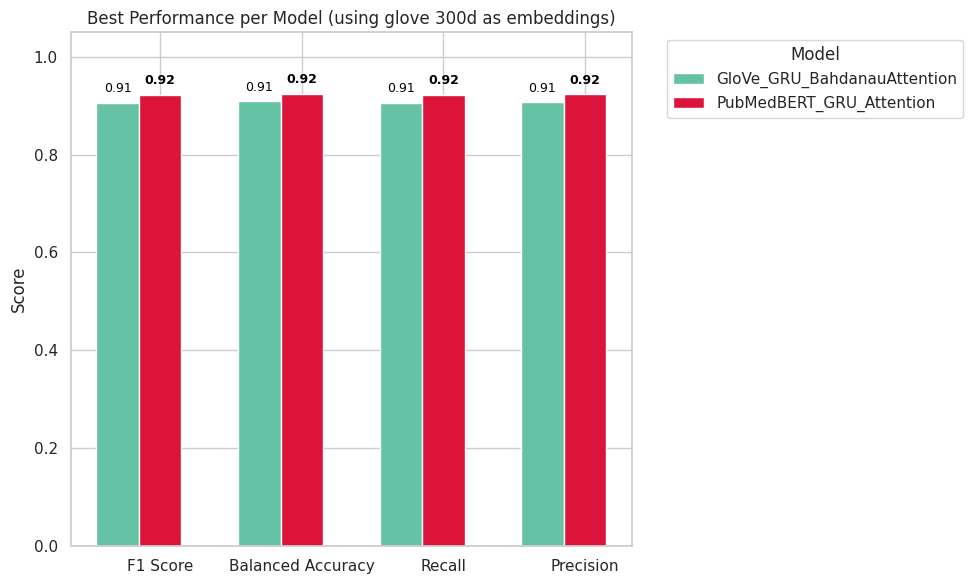

In [ ]:
summary_metrics = {
    "Model": [],
    "F1 Score": [],
    "Balanced Accuracy": [],
    "Recall": [],
    "Precision": []
}

for model_name, metrics in model_metrics.items():
    summary_metrics["Model"].append(model_name)
    summary_metrics["F1 Score"].append(max(metrics["test_f1s"]))
    summary_metrics["Balanced Accuracy"].append(max(metrics["test_balanced_accs"]))
    summary_metrics["Recall"].append(max(metrics["test_recalls"]))
    summary_metrics["Precision"].append(max(metrics["test_precisions"]))

df_summary = pd.DataFrame(summary_metrics)
df_melted = df_summary.melt(id_vars="Model", var_name="Metric", value_name="Score")

sns.set(style="whitegrid")
fig, ax = plt.subplots(figsize=(10, 6))

models = df_summary["Model"].tolist()
palette = sns.color_palette("Set2", len(models))

for i, metric in enumerate(df_melted["Metric"].unique()):
    data = df_melted[df_melted["Metric"] == metric]
    max_score = data["Score"].max()

    for j, (index, row) in enumerate(data.iterrows()):
        color = "crimson" if row["Score"] == max_score else palette[models.index(row["Model"])]
        bar = ax.bar(
            x=i - 0.3 + j * (0.6 / len(models)),
            height=row["Score"],
            width=0.6 / len(models),
            color=color,
            label=row["Model"] if i == 0 else "",
        )
        ax.text(
            x=bar[0].get_x() + bar[0].get_width() / 2,
            y=row["Score"] + 0.015,
            s=f"{row['Score']:.2f}",
            ha='center',
            va='bottom',
            fontsize=9,
            color='black',
            fontweight='bold' if row["Score"] == max_score else 'normal'
        )

ax.set_xticks(range(len(df_melted["Metric"].unique())))
ax.set_xticklabels(df_melted["Metric"].unique())
ax.set_ylim(0, 1.05)
ax.set_ylabel("Score")
ax.set_title("Best Performance per Model (using glove 300d as embeddings)")
ax.grid(True, axis='y')

handles, labels = ax.get_legend_handles_labels()
by_label = dict(zip(labels, handles))
ax.legend(by_label.values(), by_label.keys(), title="Model", bbox_to_anchor=(1.05, 1), loc="upper left")

plt.tight_layout()
plt.savefig("best_model_performance_comparison_all_values_glove300d.png")
plt.show()

---
The PubMedBERT-based model with Bidirectional GRU and Bahdanau Attention consistently outperforms the GloVe-based model with Bidirectional GRU and Bahdanau Attention across all key metrics, though by a small margin of 0.01.

This performance gain, while subtle, demonstrates that contextual embeddings like PubMedBERT provide a more nuanced and contextual understanding of biomedical text compared to traditional word embeddings like GloVe.

Furthermore, the consistency across F1 Score, Precision, Recall, and Balanced Accuracy suggests that the PubMedBERT-based model with Bidirectional GRU and Bahdanau Attention delivers more stable and generalizable predictions, which is especially valuable when dealing with class-imbalanced biomedical datasets

In [ ]:
with open("model_metrics.pkl", "wb") as f:
    pickle.dump(model_metrics, f)

with open("model_metrics.pkl", "rb") as f:
    model_metrics = pickle.load(f)

In [ ]:
test_dataset_pubMed = PubMedBERTBinaryDataset(X_test.tolist(), y_test, tokenizer)
test_dataset_glove = TextDataset(X_test_tensor, y_test, raw_text_data=X_test)

test_loader_pubMed = DataLoader(test_dataset_pubMed, batch_size=BATCH_SIZE, shuffle=False)
test_loader_glove = DataLoader(test_dataset_glove, batch_size=BATCH_SIZE, shuffle=False)

model_glove = GloVe_GRU_BahdanauAttention(embedding_matrix=embedding_matrix, hidden_dim=300, num_classes=NUM_CLASSES, num_layers=1, dropout_prob=0.9).to(device)
model_glove.load_state_dict(torch.load("/content/drive/MyDrive/GloVe_GRU_BahdanauAttention_final.pth"))

model_pubMedBert = PubMedBERT_GRU_Attention(BERT_DIM, HIDDEN_DIM, num_layers=1, dropout_prob=DROPOUT).to(device)
model_pubMedBert.load_state_dict(torch.load("/content/drive/MyDrive/PubMedBERT_GRU_Attention_early_stop.pth"))

df_results_glove, df_correct_glove, df_wrong_glove, all_labels_glove, all_probs_glove = evaluate_and_analyze_glove(model_glove, test_loader_glove, device)
df_results_pubMedBert, df_wrong_pubMedBert, df_correct_pubMedBert, all_labels_pubMedBert, all_probs_pubMedBert = evaluate_and_analyze_pubMedBert(model_pubMedBert, test_loader_pubMed, device)

<ipython-input-16-811d6649565c>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X = torch.tensor(X_data, dtype=torch.long)


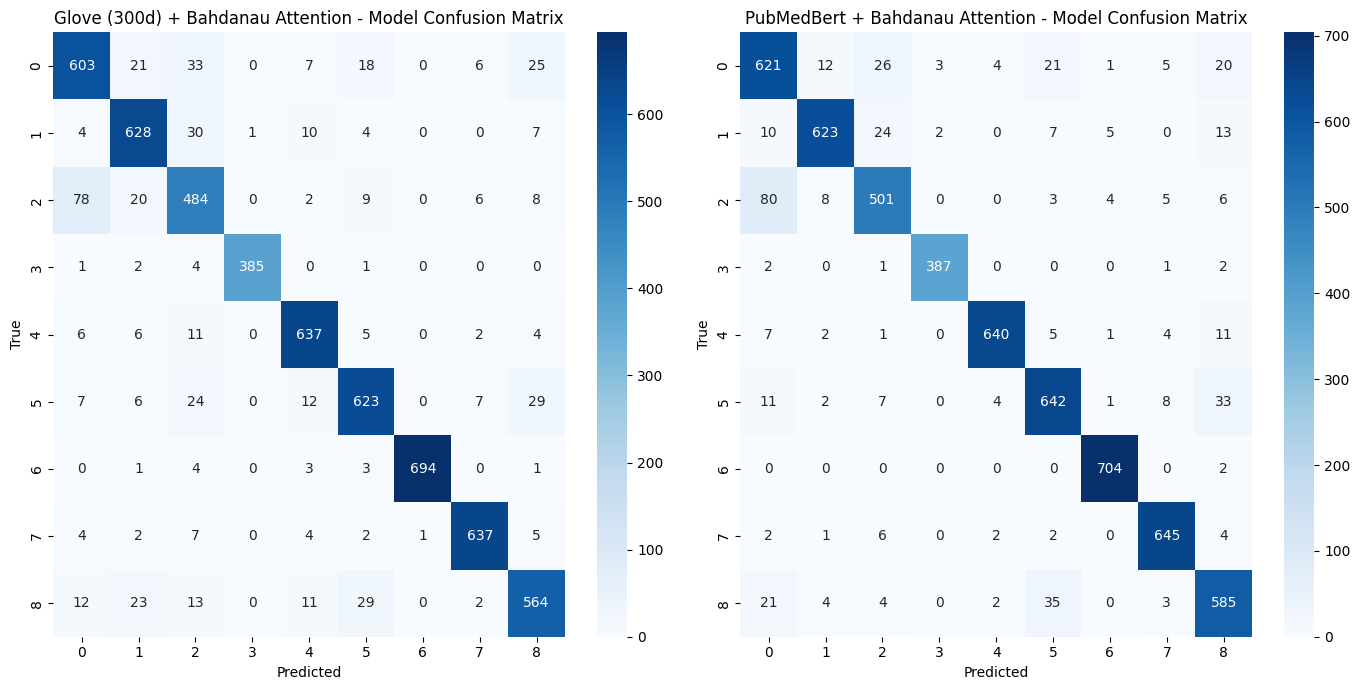

In [ ]:
all_preds_glove = np.argmax(np.array(all_probs_glove), axis=1)
all_preds_pubMedBert = np.argmax(np.array(all_probs_pubMedBert), axis=1)

fig, axes = plt.subplots(1, 2, figsize=(14, 7))

plot_confusion_matrix(axes[0], all_labels_glove, all_preds_glove, NUM_CLASSES)
axes[0].set_title("Glove (300d) + Bahdanau Attention - Model Confusion Matrix")

plot_confusion_matrix(axes[1], all_labels_pubMedBert, all_preds_pubMedBert, NUM_CLASSES)
axes[1].set_title("PubMedBert + Bahdanau Attention - Model Confusion Matrix")

plt.tight_layout()
plt.show()

### Confusion Matrix Comparison Summary

This section compares the performance of two models using confusion matrices:

- **Model 1:** GloVe (300d) as word embeddings + Bidirectional GRU + Bahdanau Attention  
- **Model 2:** PubMedBert as contextual embeddings + Bidirectional GRU + Bahdanau Attention

---

#### Key Observations

- **Overall Accuracy:**
  - The model using contextual embeddings (**PubMedBert**) outperforms the one using word embeddings (**GloVe**) in most classes, demonstrating better generalization and fewer misclassifications.

- **Diagonal Strength (Correct Predictions):**
  - **PubMedBert** shows higher or equal correct predictions in critical classes like **0, 5, and 8**.
  - Both models perform nearly identically on **class 3** and exceptionally well on **class 6**, with minimal misclassifications.

- **Common Misclassifications:**
  - **GloVe-based model** exhibits higher confusion in **class 2** and **class 8**, misclassifying several samples into other classes.
  - **PubMedBert-based model** also makes some misclassifications (notably between classes **0, 2, and 5**) but at a reduced rate.

---

#### Conclusion

> **PubMedBert + Bidirectional GRU + Bahdanau Attention** demonstrates superior performance over the **GloVe-based bidirectional GRU model**, particularly in biomedical class predictions. It consistently shows **lower off-diagonal error rates**, making it more robust and reliable for downstream tasks.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

n_classes = 9
class_names = [f'Class {i}' for i in range(n_classes)]

y_true_glove = np.array(all_labels_glove)
y_score_glove = np.array(all_probs_glove)
y_true_bin_glove = label_binarize(y_true_glove, classes=list(range(n_classes)))

y_true_pubMedBert = np.array(all_labels_pubMedBert)
y_score_pubMedBert = np.array(all_probs_pubMedBert)
y_true_bin_pubMedBert = label_binarize(y_true_pubMedBert, classes=list(range(n_classes)))

if y_score_glove.ndim != 2 or y_score_glove.shape[1] != n_classes:
    raise ValueError("y_score_glove must be an array with shape (n_samples, n_classes) containing probabilities for each class.")
if y_score_pubMedBert.ndim != 2 or y_score_pubMedBert.shape[1] != n_classes:
    raise ValueError("y_score_pubMedBert must be an array with shape (n_samples, n_classes) containing probabilities for each class.")

fpr_glove, tpr_glove, roc_auc_glove = {}, {}, {}
fpr_pubMedBert, tpr_pubMedBert, roc_auc_pubMedBert = {}, {}, {}

for i in range(n_classes):
    fpr_glove[i], tpr_glove[i], _ = roc_curve(y_true_bin_glove[:, i], y_score_glove[:, i])
    roc_auc_glove[i] = auc(fpr_glove[i], tpr_glove[i])

    fpr_pubMedBert[i], tpr_pubMedBert[i], _ = roc_curve(y_true_bin_pubMedBert[:, i], y_score_pubMedBert[:, i])
    roc_auc_pubMedBert[i] = auc(fpr_pubMedBert[i], tpr_pubMedBert[i])

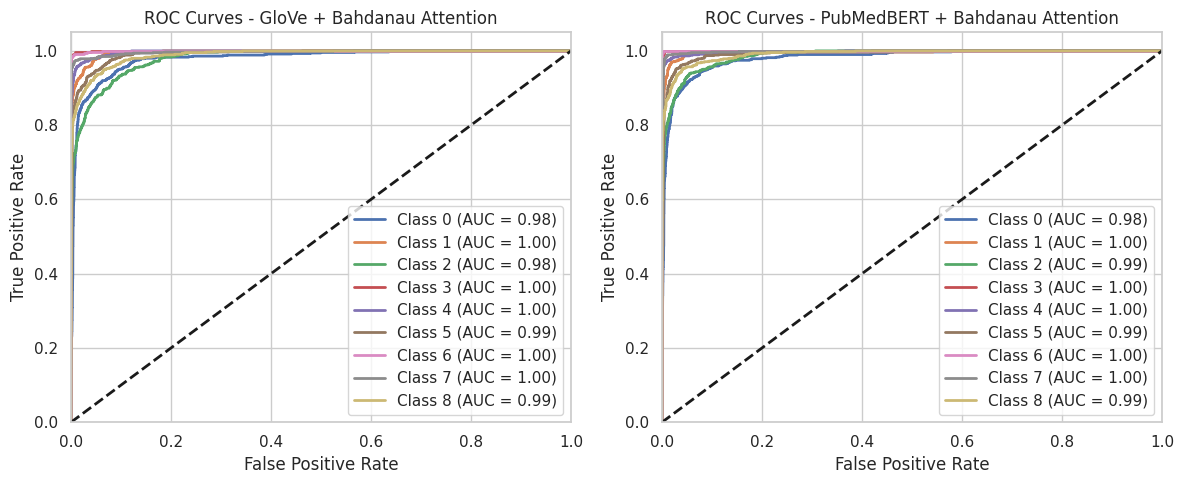

In [ ]:
sns.set(style="whitegrid")
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

for i in range(n_classes):
    axes[0].plot(fpr_glove[i], tpr_glove[i], lw=2, label=f'{class_names[i]} (AUC = {roc_auc_glove[i]:.2f})')

axes[0].plot([0, 1], [0, 1], 'k--', lw=2)
axes[0].set_xlim([0.0, 1.0])
axes[0].set_ylim([0.0, 1.05])
axes[0].set_xlabel('False Positive Rate')
axes[0].set_ylabel('True Positive Rate')
axes[0].set_title('ROC Curves - GloVe + Bahdanau Attention')
axes[0].legend(loc='lower right')
axes[0].grid(True)

for i in range(n_classes):
    axes[1].plot(fpr_pubMedBert[i], tpr_pubMedBert[i], lw=2, label=f'{class_names[i]} (AUC = {roc_auc_pubMedBert[i]:.2f})')

axes[1].plot([0, 1], [0, 1], 'k--', lw=2)
axes[1].set_xlim([0.0, 1.0])
axes[1].set_ylim([0.0, 1.05])
axes[1].set_xlabel('False Positive Rate')
axes[1].set_ylabel('True Positive Rate')
axes[1].set_title('ROC Curves - PubMedBERT + Bahdanau Attention')
axes[1].legend(loc='lower right')
axes[1].grid(True)

plt.tight_layout()
plt.show()

### ROC Curve Interpretation

These are ROC (Receiver Operating Characteristic) curves for a multi-class classification task. The closer each curve is to the top-left corner, the better the model is at distinguishing between classes. The diagonal line represents random guessing—so curves well above this line indicate strong classification performance.

Both models—GloVe + Bahdanau Attention and PubMedBERT + Bahdanau Attention—show excellent results across all classes. However, PubMedBERT exhibits slightly more consistent and higher AUC scores, indicating a modest performance advantage.

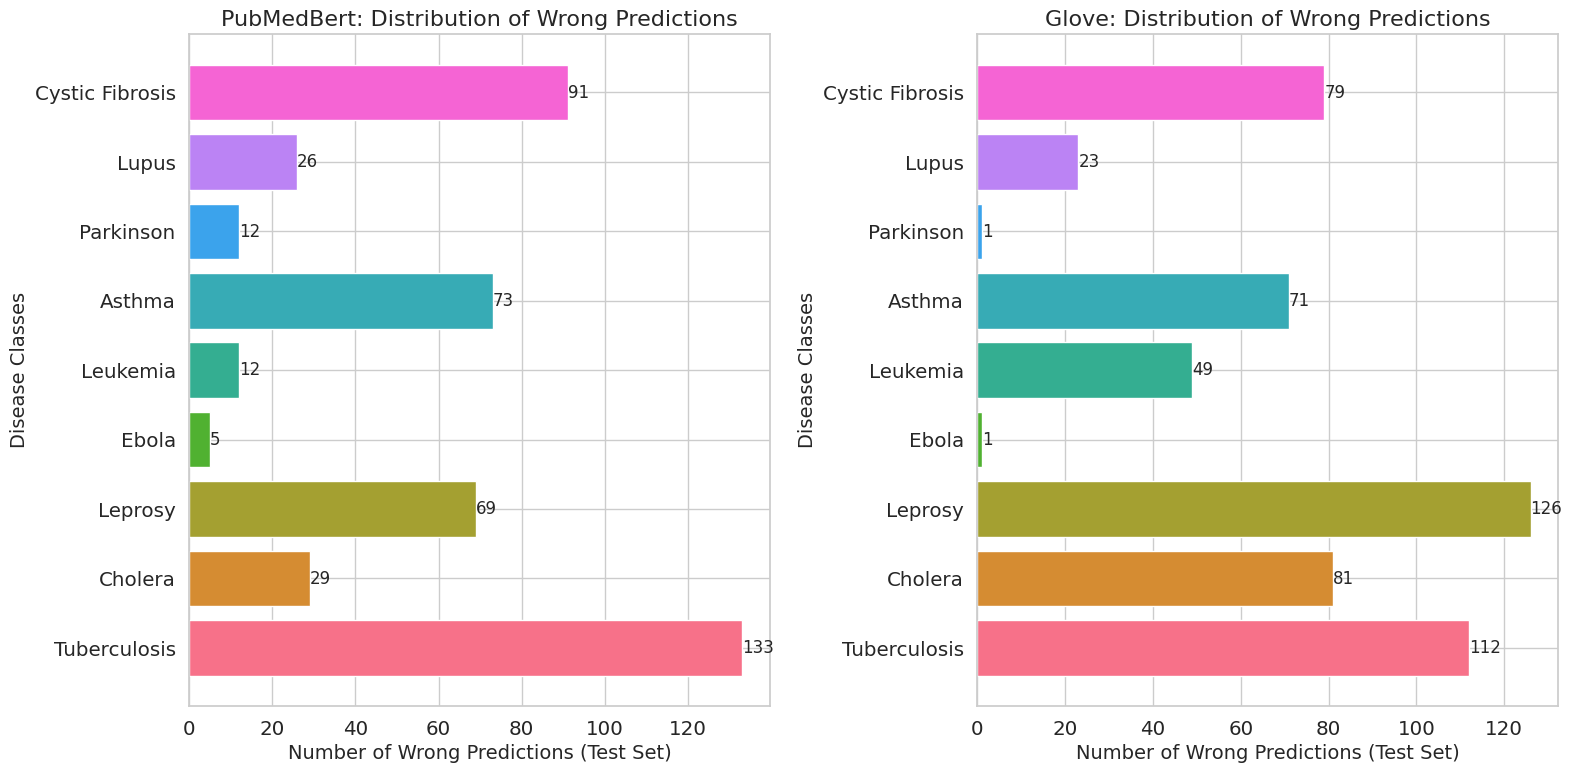

In [ ]:
class_names_dict = {
    0: 'Tuberculosis',
    1: 'Cholera',
    2: 'Leprosy',
    3: 'Ebola',
    4: 'Leukemia',
    5: 'Asthma',
    6: 'Parkinson',
    7: 'Lupus',
    8: 'Cystic Fibrosis'
}

wrong_df_pubMedBert = pd.DataFrame({'predictions': all_preds_pubMedBert, 'labels': all_labels_pubMedBert})
wrong_df_pubMedBert['wrong'] = wrong_df_pubMedBert['predictions'] != wrong_df_pubMedBert['labels']

wrong_df_glove = pd.DataFrame({'predictions': all_preds_glove, 'labels': all_labels_glove})
wrong_df_glove['wrong'] = wrong_df_glove['predictions'] != wrong_df_glove['labels']

def get_wrong_counts(df):
    wrong_class_counts = defaultdict(int)
    for _, row in df.iterrows():
        if row['wrong']:
            wrong_class_counts[row['predictions']] += 1
    wrong_class_labels = sorted(wrong_class_counts.keys())
    wrong_counts = [wrong_class_counts[label] for label in wrong_class_labels]
    return wrong_class_labels, wrong_counts

wrong_class_labels_pubMedBert, wrong_counts_pubMedBert = get_wrong_counts(wrong_df_pubMedBert)
wrong_class_labels_glove, wrong_counts_glove = get_wrong_counts(wrong_df_glove)


sns.set(style="whitegrid", palette="muted", font_scale=1.3)
fig, axes = plt.subplots(1, 2, figsize=(16, 8))

wrong_colors_pubMedBert = sns.color_palette("husl", len(wrong_class_labels_pubMedBert))
class_names_pubMedBert = [class_names_dict[label] for label in wrong_class_labels_pubMedBert]
axes[0].barh(class_names_pubMedBert, wrong_counts_pubMedBert, color=wrong_colors_pubMedBert)
axes[0].set_xlabel('Number of Wrong Predictions (Test Set)', fontsize=14)
axes[0].set_ylabel('Disease Classes', fontsize=14)
axes[0].set_title('PubMedBert: Distribution of Wrong Predictions', fontsize=16)
for i, (count, name) in enumerate(zip(wrong_counts_pubMedBert, class_names_pubMedBert)):
    axes[0].text(count, i, str(count), ha='left', va='center', fontsize=12)

wrong_colors_glove = sns.color_palette("husl", len(wrong_class_labels_glove))
class_names_glove = [class_names_dict[label] for label in wrong_class_labels_glove]
axes[1].barh(class_names_glove, wrong_counts_glove, color=wrong_colors_glove)
axes[1].set_xlabel('Number of Wrong Predictions (Test Set)', fontsize=14)
axes[1].set_ylabel('Disease Classes', fontsize=14)
axes[1].set_title('Glove: Distribution of Wrong Predictions', fontsize=16)
for i, (count, name) in enumerate(zip(wrong_counts_glove, class_names_glove)):
    axes[1].text(count, i, str(count), ha='left', va='center', fontsize=12)

plt.tight_layout()
plt.show()

---

**Summary**


Using PubMedBert enables to achieve lower misclassification rates in 5 out of 9 disease classes, especially for:

Leprosy: 45% fewer wrong predictions

Cholera: 64% fewer wrong predictions

Leukemia: 75% fewer wrong predictions

Using GloVe enables to perform slightly better in Parkinson, Ebola, and Tuberculosis.

Tuberculosis remains the most challenging class for both models, especially PubMedBert.

Voici la table mise à jour avec les meilleures valeurs de chaque colonne mises en **gras** :

---

# **Model Performance Comparison**

| **Model**                               | **Input Type**        | **Accuracy** | **Balanced Accuracy** | **F1 Score** | **Recall** | **Precision** |
|-----------------------------------------|-----------------------|--------------|-----------------------|--------------|------------|---------------|
| **GRU**                                 | No embeddings          | 87.74%       | 88.00%                | 87.78%       | 87.74%     | 88.00%        |
| **LSTM**                                | No embeddings          | 88.13%       | 88.46%                | 88.36%       | 88.13%     | 88.88%        |
| **CNN + GRU**                           | No embeddings          | 86.77%       | 87.09%                | 87.11%       | 86.77%     | 88.35%        |
| **CNN + LSTM**                          | No embeddings          | 88.13%       | 88.40%                | 88.36%       | 88.13%     | 89.34%        |
| **GRU**                                 | GloVe (300d)           | **92.17%**   | **92.36%**            | **92.15%**   | **92.17%** | **92.21%**    |
| **LSTM**                                | GloVe (300d)           | 88.34%       | 88.82%                | 88.41%       | 88.34%     | 89.07%        |
| **CNN + GRU**                           | GloVe (300d)           | 89.70%       | 89.86%                | 89.65%       | 89.70%     | 89.74%        |
| **CNN + LSTM**                          | GloVe (300d)           | 88.88%       | 89.13%                | 88.97%       | 88.88%     | 89.60%        |
| **Bidirectional GRU + Bahdanau Attention** | **PubMedBERT**         | **92.00%**       | **92.28%**            | **92.01%**       | **92.00%**     | **92.06%**        |
| **Bidirectional GRU + Bahdanau Attention** | GloVe (300d)           | **90.63%**       | **90.86%**                | **90.64%**       | **90.63%**     | **90.67%**        |

---
Given the imbalance in the dataset, we are now tackling this issue by implementing techniques such as SMOTE, weighted training, and ADASYN. We will evaluate their impact by measuring improvements in model performance and the balance of the data distribution.